In [1]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device= torch.device("cuda"if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Data

In [4]:
df=pd.read_csv("data/Sunspots.csv",index_col="Date",parse_dates=["Date"])
df

,Monthly_Mean_Sunspot
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7
...,...
2020-09-30,0.6
2020-10-31,14.4
2020-11-30,34.0


C:\Users\Rahmat\anaconda3\envs\jcop\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


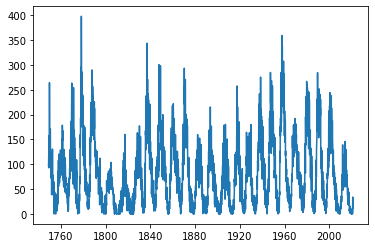

In [5]:
plt.plot(df.Monthly_Mean_Sunspot)

In [6]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit(df[['Monthly_Mean_Sunspot']])

# df['Monthly_Mean_Sunspot'] = scaler.transform(df[['Monthly_Mean_Sunspot']])

# Dataset Splitting

In [7]:
from sklearn.model_selection import train_test_split

In [8]:

ts_train, ts_test = train_test_split(df, test_size=0.2,shuffle=False)
ts_train.shape, ts_test.shape

((2612, 1), (653, 1))

# Dataset and Dataloader

In [9]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

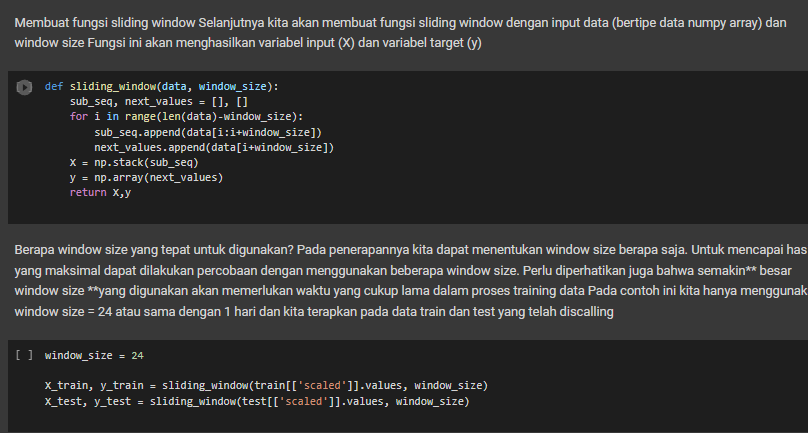

In [10]:
seq_len= 12
bs=64

train_set= TimeSeriesDataset(ts_train,"Monthly_Mean_Sunspot",seq_len)
trainloader=DataLoader(train_set,batch_size=bs)

test_set=TimeSeriesDataset(ts_test,"Monthly_Mean_Sunspot",seq_len)
testloader= DataLoader(test_set,batch_size=bs)

(N, S, F): (217, 12, 1)
Note: last 7 data excluded

(N, S, F): (54, 12, 1)
Note: last 4 data excluded



# Arsitektur and Config

In [11]:
class RNN (nn.Module):
    def __init__(self,input_size,output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.hidden= nn.RNN(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
        
    def forward(self,x,hidden):
        x,hidden= self.hidden(x,hidden)
        x= self.fc(x)
        return x,hidden

In [12]:
config = set_config({
    "batch_size" : bs,
    "seq_len" : train_set.n_seq,
    "input_size" : train_set.n_feature,
    "output_size" : 1,
    "hidden_size" : 128,
    "num_layers" : 2,
    "dropout": 0
})

# Training Preparation ~> MCOC

In [13]:
model = RNN(config.input_size,config.output_size,config.hidden_size,config.num_layers,config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model,config,outdir="model")


# Training Loop

In [14]:
def loop_fn (mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode =="train":
        model.train()
    elif mode == "test":
        model.eval()
        
    cost = 0
    for feature,target in tqdm(dataloader,desc = mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature,None) 
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item()*feature.shape[0]
    cost=cost/len(dataset)
    return cost

In [15]:
from tqdm.auto import tqdm



Epoch     1
Train_cost  = 10875.6388 | Test_cost  = 11881.6602 | 




Epoch     2
Train_cost  = 10469.7082 | Test_cost  = 11583.8896 | 




Epoch     3
Train_cost  = 10243.6132 | Test_cost  = 11427.0156 | 




Epoch     4
Train_cost  = 10118.6859 | Test_cost  = 11322.3564 | 




Epoch     5
Train_cost  = 10027.5293 | Test_cost  = 11230.5898 | 




Epoch     6
Train_cost  = 9944.4302 | Test_cost  = 11141.7979 | 




Epoch     7
Train_cost  = 9863.4419 | Test_cost  = 11054.4365 | 




Epoch     8
Train_cost  = 9783.7749 | Test_cost  = 10968.3770 | 




Epoch     9
Train_cost  = 9705.3115 | Test_cost  = 10883.5234 | 




Epoch    10
Train_cost  = 9627.9957 | Test_cost  = 10799.8662 | 




Epoch    11
Train_cost  = 9551.8206 | Test_cost  = 10717.4043 | 




Epoch    12
Train_cost  = 9476.7810 | Test_cost  = 10636.1162 | 




Epoch    13
Train_cost  = 9402.8569 | Test_cost  = 10555.9844 | 




Epoch    14
Train_cost  = 9330.0251 | Test_cost  = 10476.9756 | 




Epoch    15
Train_cost  = 9258.2542 | Test_cost  = 10399.0527 | 




Epoch    16
Train_cost  = 9187.5125 | Test_cost  = 10322.1855 | 




Epoch    17
Train_cost  = 9117.7669 | Test_cost  = 10246.3389 | 




Epoch    18
Train_cost  = 9048.9902 | Test_cost  = 10171.4834 | 




Epoch    19
Train_cost  = 8981.1496 | Test_cost  = 10097.5879 | 




Epoch    20
Train_cost  = 8914.2221 | Test_cost  = 10024.6279 | 


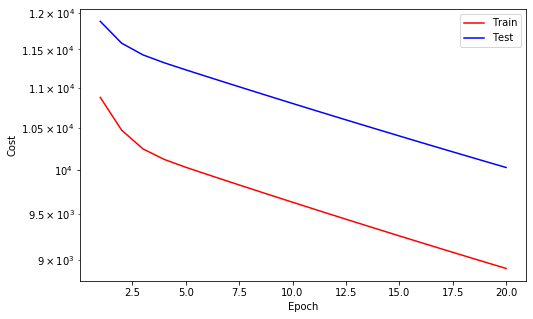



Epoch    21
Train_cost  = 8848.1792 | Test_cost  = 9952.5791 | 




Epoch    22
Train_cost  = 8782.9993 | Test_cost  = 9881.4180 | 




Epoch    23
Train_cost  = 8718.6576 | Test_cost  = 9811.1201 | 




Epoch    24
Train_cost  = 8655.1315 | Test_cost  = 9741.6660 | 




Epoch    25
Train_cost  = 8592.3902 | Test_cost  = 9673.0303 | 




Epoch    26
Train_cost  = 8530.3798 | Test_cost  = 9605.1846 | 




Epoch    27
Train_cost  = 8468.7327 | Test_cost  = 9538.0908 | 




Epoch    28
Train_cost  = 8409.3338 | Test_cost  = 9471.8848 | 




Epoch    29
Train_cost  = 8348.1357 | Test_cost  = 9406.4629 | 




Epoch    30
Train_cost  = 8289.9725 | Test_cost  = 9341.7207 | 




Epoch    31
Train_cost  = 8231.8142 | Test_cost  = 9277.5703 | 




Epoch    32
Train_cost  = 8174.0714 | Test_cost  = 9213.8076 | 




Epoch    33
Train_cost  = 8116.5125 | Test_cost  = 9149.8525 | 




Epoch    34
Train_cost  = 8058.1022 | Test_cost  = 9083.6211 | 




Epoch    35
Train_cost  = 7997.2849 | Test_cost  = 9018.0977 | 




Epoch    36
Train_cost  = 7941.8366 | Test_cost  = 8955.2734 | 




Epoch    37
Train_cost  = 7885.1149 | Test_cost  = 8895.8506 | 




Epoch    38
Train_cost  = 7830.4541 | Test_cost  = 8835.0391 | 




Epoch    39
Train_cost  = 7775.8208 | Test_cost  = 8772.1670 | 




Epoch    40
Train_cost  = 7720.3146 | Test_cost  = 8708.9199 | 


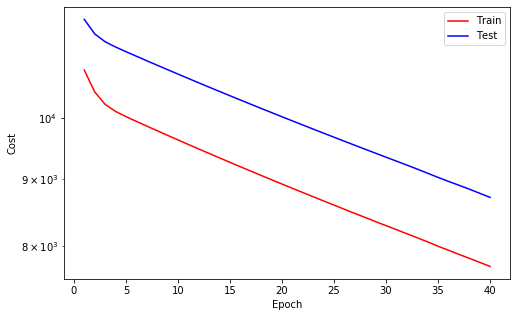



Epoch    41
Train_cost  = 7664.4291 | Test_cost  = 8646.8066 | 




Epoch    42
Train_cost  = 7612.2019 | Test_cost  = 8586.8291 | 




Epoch    43
Train_cost  = 7558.0409 | Test_cost  = 8528.9287 | 




Epoch    44
Train_cost  = 7503.9175 | Test_cost  = 8469.9482 | 




Epoch    45
Train_cost  = 7451.1902 | Test_cost  = 8409.9424 | 




Epoch    46
Train_cost  = 7398.4210 | Test_cost  = 8350.9658 | 




Epoch    47
Train_cost  = 7345.8836 | Test_cost  = 8292.8604 | 




Epoch    48
Train_cost  = 7293.5036 | Test_cost  = 8235.9941 | 




Epoch    49
Train_cost  = 7241.4472 | Test_cost  = 8178.9785 | 




Epoch    50
Train_cost  = 7190.4356 | Test_cost  = 8123.3989 | 




Epoch    51
Train_cost  = 7140.2123 | Test_cost  = 8068.5396 | 




Epoch    52
Train_cost  = 7090.6583 | Test_cost  = 8013.3525 | 




Epoch    53
Train_cost  = 7041.4220 | Test_cost  = 7958.1475 | 




Epoch    54
Train_cost  = 6992.7422 | Test_cost  = 7903.6831 | 




Epoch    55
Train_cost  = 6944.5039 | Test_cost  = 7849.6367 | 




Epoch    56
Train_cost  = 6896.6364 | Test_cost  = 7795.9111 | 




Epoch    57
Train_cost  = 6849.2452 | Test_cost  = 7743.0171 | 




Epoch    58
Train_cost  = 6802.2438 | Test_cost  = 7690.5210 | 




Epoch    59
Train_cost  = 6755.6104 | Test_cost  = 7638.3828 | 




Epoch    60
Train_cost  = 6709.4099 | Test_cost  = 7586.8193 | 


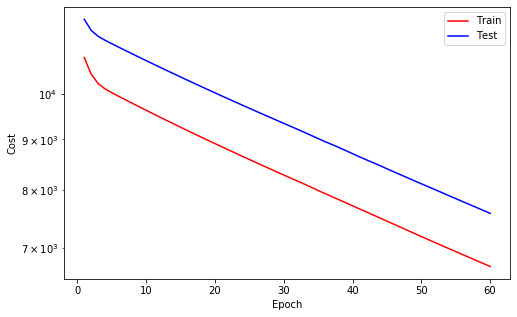



Epoch    61
Train_cost  = 6663.5974 | Test_cost  = 7535.4761 | 




Epoch    62
Train_cost  = 6618.1897 | Test_cost  = 7484.6055 | 




Epoch    63
Train_cost  = 6573.1920 | Test_cost  = 7434.1460 | 




Epoch    64
Train_cost  = 6528.5850 | Test_cost  = 7384.0972 | 




Epoch    65
Train_cost  = 6484.3789 | Test_cost  = 7334.5156 | 




Epoch    66
Train_cost  = 6440.5485 | Test_cost  = 7285.3481 | 




Epoch    67
Train_cost  = 6397.1102 | Test_cost  = 7236.5874 | 




Epoch    68
Train_cost  = 6354.0531 | Test_cost  = 7188.2344 | 




Epoch    69
Train_cost  = 6311.3831 | Test_cost  = 7140.2236 | 




Epoch    70
Train_cost  = 6269.0912 | Test_cost  = 7092.6885 | 




Epoch    71
Train_cost  = 6227.1856 | Test_cost  = 7045.5024 | 




Epoch    72
Train_cost  = 6185.6527 | Test_cost  = 6998.7993 | 




Epoch    73
Train_cost  = 6144.4900 | Test_cost  = 6952.4668 | 




Epoch    74
Train_cost  = 6103.6989 | Test_cost  = 6906.5107 | 




Epoch    75
Train_cost  = 6063.2716 | Test_cost  = 6860.9771 | 




Epoch    76
Train_cost  = 6023.2014 | Test_cost  = 6815.7939 | 




Epoch    77
Train_cost  = 5983.4875 | Test_cost  = 6770.9805 | 




Epoch    78
Train_cost  = 5944.1162 | Test_cost  = 6726.5669 | 




Epoch    79
Train_cost  = 5905.0889 | Test_cost  = 6682.5054 | 




Epoch    80
Train_cost  = 5866.4074 | Test_cost  = 6638.8188 | 


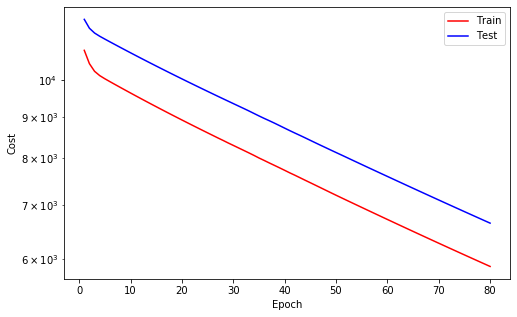



Epoch    81
Train_cost  = 5828.0606 | Test_cost  = 6595.5063 | 




Epoch    82
Train_cost  = 5790.0466 | Test_cost  = 6552.5503 | 




Epoch    83
Train_cost  = 5752.3587 | Test_cost  = 6509.9365 | 




Epoch    84
Train_cost  = 5714.9929 | Test_cost  = 6467.6626 | 




Epoch    85
Train_cost  = 5677.9393 | Test_cost  = 6425.7290 | 




Epoch    86
Train_cost  = 5641.1949 | Test_cost  = 6384.1279 | 




Epoch    87
Train_cost  = 5604.7615 | Test_cost  = 6342.8394 | 




Epoch    88
Train_cost  = 5568.6462 | Test_cost  = 6301.8555 | 




Epoch    89
Train_cost  = 5532.8507 | Test_cost  = 6261.1958 | 




Epoch    90
Train_cost  = 5497.3667 | Test_cost  = 6220.8774 | 




Epoch    91
Train_cost  = 5462.1663 | Test_cost  = 6180.9102 | 




Epoch    92
Train_cost  = 5427.2253 | Test_cost  = 6141.3096 | 




Epoch    93
Train_cost  = 5392.5439 | Test_cost  = 6102.0801 | 




Epoch    94
Train_cost  = 5358.1449 | Test_cost  = 6063.1958 | 




Epoch    95
Train_cost  = 5324.0597 | Test_cost  = 6024.7886 | 




Epoch    96
Train_cost  = 5290.5769 | Test_cost  = 5987.0415 | 




Epoch    97
Train_cost  = 5258.0480 | Test_cost  = 5948.7417 | 




Epoch    98
Train_cost  = 5225.7820 | Test_cost  = 5914.5322 | 




Epoch    99
Train_cost  = 5192.7111 | Test_cost  = 5876.7109 | 




Epoch   100
Train_cost  = 5161.2398 | Test_cost  = 5838.2769 | 


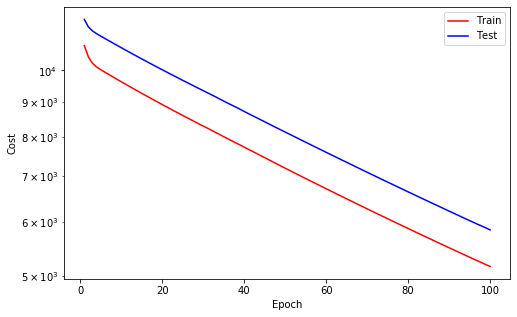



Epoch   101
Train_cost  = 5127.0131 | Test_cost  = 5798.9180 | 




Epoch   102
Train_cost  = 5094.2029 | Test_cost  = 5761.4497 | 




Epoch   103
Train_cost  = 5062.5915 | Test_cost  = 5725.2778 | 




Epoch   104
Train_cost  = 5030.7554 | Test_cost  = 5690.4746 | 




Epoch   105
Train_cost  = 4999.1037 | Test_cost  = 5654.3140 | 




Epoch   106
Train_cost  = 4968.1895 | Test_cost  = 5618.4829 | 




Epoch   107
Train_cost  = 4936.8609 | Test_cost  = 5583.1680 | 




Epoch   108
Train_cost  = 4906.5396 | Test_cost  = 5548.7617 | 




Epoch   109
Train_cost  = 4876.2076 | Test_cost  = 5513.7490 | 




Epoch   110
Train_cost  = 4845.7328 | Test_cost  = 5479.7422 | 




Epoch   111
Train_cost  = 4815.6678 | Test_cost  = 5444.6133 | 




Epoch   112
Train_cost  = 4785.9321 | Test_cost  = 5410.9805 | 




Epoch   113
Train_cost  = 4756.7678 | Test_cost  = 5378.7905 | 




Epoch   114
Train_cost  = 4727.6898 | Test_cost  = 5345.7417 | 




Epoch   115
Train_cost  = 4699.0298 | Test_cost  = 5311.4819 | 




Epoch   116
Train_cost  = 4670.0867 | Test_cost  = 5279.1533 | 




Epoch   117
Train_cost  = 4641.1226 | Test_cost  = 5248.7046 | 




Epoch   118
Train_cost  = 4613.1213 | Test_cost  = 5214.5674 | 




Epoch   119
Train_cost  = 4584.1448 | Test_cost  = 5180.9053 | 




Epoch   120
Train_cost  = 4556.8961 | Test_cost  = 5150.8027 | 


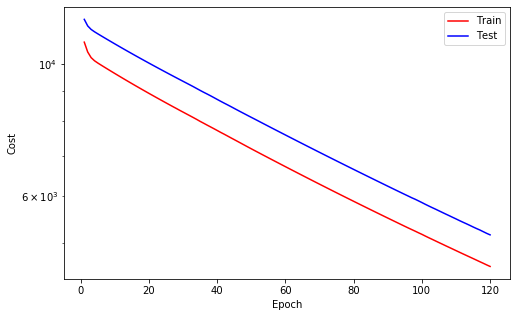



Epoch   121
Train_cost  = 4529.6957 | Test_cost  = 5118.1748 | 




Epoch   122
Train_cost  = 4501.1150 | Test_cost  = 5088.7661 | 




Epoch   123
Train_cost  = 4473.4847 | Test_cost  = 5053.9336 | 




Epoch   124
Train_cost  = 4445.7746 | Test_cost  = 5025.2358 | 




Epoch   125
Train_cost  = 4419.4785 | Test_cost  = 4994.2393 | 




Epoch   126
Train_cost  = 4392.6036 | Test_cost  = 4964.5913 | 




Epoch   127
Train_cost  = 4365.5317 | Test_cost  = 4932.6865 | 




Epoch   128
Train_cost  = 4338.6862 | Test_cost  = 4902.1274 | 




Epoch   129
Train_cost  = 4312.3899 | Test_cost  = 4874.1782 | 




Epoch   130
Train_cost  = 4286.5908 | Test_cost  = 4843.0830 | 




Epoch   131
Train_cost  = 4261.0122 | Test_cost  = 4814.4971 | 




Epoch   132
Train_cost  = 4235.9191 | Test_cost  = 4784.1680 | 




Epoch   133
Train_cost  = 4209.4080 | Test_cost  = 4757.1348 | 




Epoch   134
Train_cost  = 4183.8759 | Test_cost  = 4726.6064 | 




Epoch   135
Train_cost  = 4158.9164 | Test_cost  = 4698.3301 | 




Epoch   136
Train_cost  = 4134.2198 | Test_cost  = 4669.6221 | 




Epoch   137
Train_cost  = 4110.2061 | Test_cost  = 4642.8594 | 




Epoch   138
Train_cost  = 4086.2208 | Test_cost  = 4616.2251 | 




Epoch   139
Train_cost  = 4062.1908 | Test_cost  = 4585.2759 | 




Epoch   140
Train_cost  = 4037.5256 | Test_cost  = 4559.1797 | 


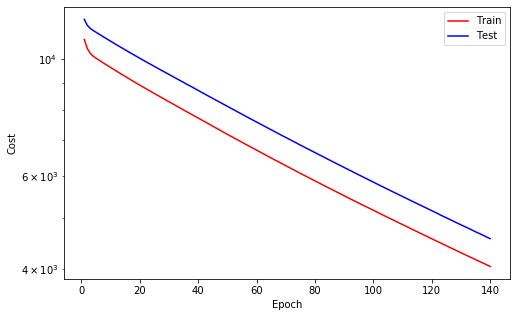



Epoch   141
Train_cost  = 4013.3482 | Test_cost  = 4533.8506 | 




Epoch   142
Train_cost  = 3990.6059 | Test_cost  = 4504.7695 | 




Epoch   143
Train_cost  = 3967.6745 | Test_cost  = 4478.8257 | 




Epoch   144
Train_cost  = 3946.4793 | Test_cost  = 4451.4897 | 




Epoch   145
Train_cost  = 3921.6434 | Test_cost  = 4426.5020 | 




Epoch   146
Train_cost  = 3898.2214 | Test_cost  = 4395.4180 | 




Epoch   147
Train_cost  = 3875.3871 | Test_cost  = 4372.1797 | 




Epoch   148
Train_cost  = 3853.7014 | Test_cost  = 4345.8374 | 




Epoch   149
Train_cost  = 3830.5763 | Test_cost  = 4320.4272 | 




Epoch   150
Train_cost  = 3807.2026 | Test_cost  = 4290.5918 | 




Epoch   151
Train_cost  = 3786.3068 | Test_cost  = 4267.2939 | 




Epoch   152
Train_cost  = 3764.2406 | Test_cost  = 4244.0010 | 




Epoch   153
Train_cost  = 3741.5570 | Test_cost  = 4216.7656 | 




Epoch   154
Train_cost  = 3720.1082 | Test_cost  = 4193.3735 | 




Epoch   155
Train_cost  = 3698.5179 | Test_cost  = 4169.3042 | 




Epoch   156
Train_cost  = 3678.0431 | Test_cost  = 4145.2739 | 




Epoch   157
Train_cost  = 3656.4729 | Test_cost  = 4119.7617 | 




Epoch   158
Train_cost  = 3635.3802 | Test_cost  = 4097.3960 | 




Epoch   159
Train_cost  = 3614.5155 | Test_cost  = 4073.6704 | 




Epoch   160
Train_cost  = 3594.4541 | Test_cost  = 4054.7532 | 


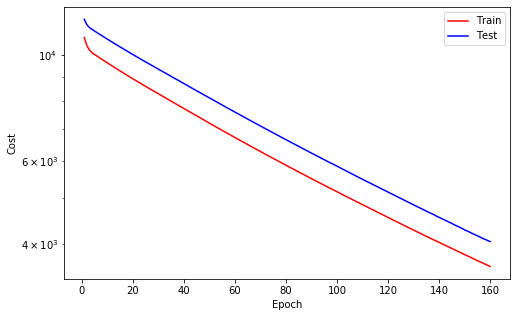



Epoch   161
Train_cost  = 3575.3464 | Test_cost  = 4028.0830 | 




Epoch   162
Train_cost  = 3553.9501 | Test_cost  = 4004.6677 | 




Epoch   163
Train_cost  = 3534.5028 | Test_cost  = 3984.6455 | 




Epoch   164
Train_cost  = 3514.3845 | Test_cost  = 3960.2573 | 




Epoch   165
Train_cost  = 3494.3712 | Test_cost  = 3942.1963 | 




Epoch   166
Train_cost  = 3476.8521 | Test_cost  = 3921.8765 | 




Epoch   167
Train_cost  = 3459.5992 | Test_cost  = 3891.2488 | 




Epoch   168
Train_cost  = 3439.0865 | Test_cost  = 3871.2222 | 




Epoch   169
Train_cost  = 3418.2626 | Test_cost  = 3850.3545 | 




Epoch   170
Train_cost  = 3401.1441 | Test_cost  = 3836.4197 | 




Epoch   171
Train_cost  = 3383.6608 | Test_cost  = 3806.4102 | 




Epoch   172
Train_cost  = 3362.9755 | Test_cost  = 3786.9084 | 




Epoch   173
Train_cost  = 3342.9394 | Test_cost  = 3764.9792 | 




Epoch   174
Train_cost  = 3325.7982 | Test_cost  = 3747.7559 | 




Epoch   175
Train_cost  = 3306.8923 | Test_cost  = 3724.5640 | 




Epoch   176
Train_cost  = 3286.9765 | Test_cost  = 3702.7959 | 




Epoch   177
Train_cost  = 3269.1947 | Test_cost  = 3682.3140 | 




Epoch   178
Train_cost  = 3251.8764 | Test_cost  = 3663.5400 | 




Epoch   179
Train_cost  = 3235.1950 | Test_cost  = 3642.8884 | 




Epoch   180
Train_cost  = 3217.9287 | Test_cost  = 3619.1704 | 


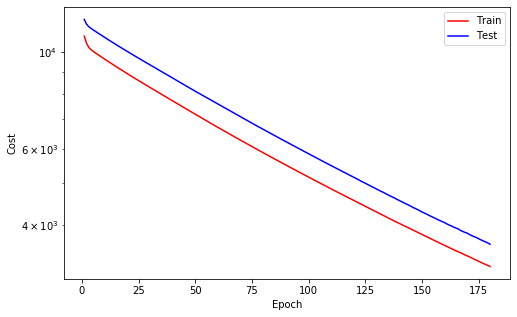



Epoch   181
Train_cost  = 3199.4405 | Test_cost  = 3601.8499 | 




Epoch   182
Train_cost  = 3184.0279 | Test_cost  = 3590.5254 | 




Epoch   183
Train_cost  = 3169.7291 | Test_cost  = 3569.4136 | 




Epoch   184
Train_cost  = 3152.0152 | Test_cost  = 3543.4155 | 




Epoch   185
Train_cost  = 3135.2234 | Test_cost  = 3524.6570 | 




Epoch   186
Train_cost  = 3117.3513 | Test_cost  = 3503.3950 | 




Epoch   187
Train_cost  = 3103.6482 | Test_cost  = 3490.2778 | 




Epoch   188
Train_cost  = 3084.5223 | Test_cost  = 3464.4756 | 




Epoch   189
Train_cost  = 3066.4445 | Test_cost  = 3447.3250 | 




Epoch   190
Train_cost  = 3050.9490 | Test_cost  = 3433.8057 | 




Epoch   191
Train_cost  = 3037.9073 | Test_cost  = 3408.6982 | 




Epoch   192
Train_cost  = 3021.7257 | Test_cost  = 3392.5193 | 




Epoch   193
Train_cost  = 3002.6441 | Test_cost  = 3368.5559 | 




Epoch   194
Train_cost  = 2986.4295 | Test_cost  = 3358.8857 | 




Epoch   195
Train_cost  = 2978.2032 | Test_cost  = 3336.8198 | 




Epoch   196
Train_cost  = 2962.3769 | Test_cost  = 3314.9189 | 




Epoch   197
Train_cost  = 2945.2176 | Test_cost  = 3295.3516 | 




Epoch   198
Train_cost  = 2925.7037 | Test_cost  = 3293.0244 | 




Epoch   199
Train_cost  = 2912.6261 | Test_cost  = 3268.7542 | 




Epoch   200
Train_cost  = 2897.5809 | Test_cost  = 3239.9250 | 


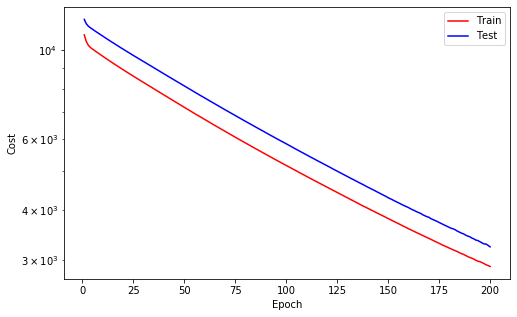



Epoch   201
Train_cost  = 2882.9031 | Test_cost  = 3229.1135 | 




Epoch   202
Train_cost  = 2863.6653 | Test_cost  = 3215.1348 | 




Epoch   203
Train_cost  = 2852.6255 | Test_cost  = 3198.3064 | 




Epoch   204
Train_cost  = 2838.1542 | Test_cost  = 3179.5464 | 




Epoch   205
Train_cost  = 2820.5664 | Test_cost  = 3156.5061 | 




Epoch   206
Train_cost  = 2805.4305 | Test_cost  = 3151.5100 | 




Epoch   207
Train_cost  = 2795.5535 | Test_cost  = 3130.0134 | 




Epoch   208
Train_cost  = 2782.9663 | Test_cost  = 3113.4302 | 




Epoch   209
Train_cost  = 2766.7758 | Test_cost  = 3091.0312 | 




Epoch   210
Train_cost  = 2751.3440 | Test_cost  = 3081.2051 | 




Epoch   211
Train_cost  = 2736.3254 | Test_cost  = 3063.5215 | 




Epoch   212
Train_cost  = 2721.4384 | Test_cost  = 3045.7583 | 




Epoch   213
Train_cost  = 2707.9012 | Test_cost  = 3030.6294 | 




Epoch   214
Train_cost  = 2694.0146 | Test_cost  = 3020.7837 | 




Epoch   215
Train_cost  = 2682.9156 | Test_cost  = 3002.9961 | 




Epoch   216
Train_cost  = 2667.8931 | Test_cost  = 2982.4622 | 




Epoch   217
Train_cost  = 2655.2334 | Test_cost  = 2965.7593 | 




Epoch   218
Train_cost  = 2640.5459 | Test_cost  = 2952.7441 | 




Epoch   219
Train_cost  = 2628.1302 | Test_cost  = 2943.6067 | 




Epoch   220
Train_cost  = 2614.8361 | Test_cost  = 2922.6589 | 


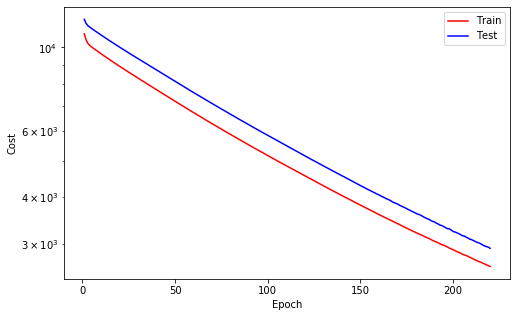



Epoch   221
Train_cost  = 2602.4244 | Test_cost  = 2908.5610 | 




Epoch   222
Train_cost  = 2590.4282 | Test_cost  = 2888.0835 | 




Epoch   223
Train_cost  = 2577.2731 | Test_cost  = 2878.1003 | 




Epoch   224
Train_cost  = 2565.4541 | Test_cost  = 2864.2822 | 




Epoch   225
Train_cost  = 2551.1082 | Test_cost  = 2854.6909 | 




Epoch   226
Train_cost  = 2543.6744 | Test_cost  = 2832.3706 | 




Epoch   227
Train_cost  = 2529.7260 | Test_cost  = 2814.4160 | 




Epoch   228
Train_cost  = 2517.8358 | Test_cost  = 2801.8010 | 




Epoch   229
Train_cost  = 2506.8103 | Test_cost  = 2791.6484 | 




Epoch   230
Train_cost  = 2491.0154 | Test_cost  = 2782.0867 | 




Epoch   231
Train_cost  = 2485.7579 | Test_cost  = 2766.1458 | 




Epoch   232
Train_cost  = 2470.4267 | Test_cost  = 2742.6013 | 




Epoch   233
Train_cost  = 2459.2260 | Test_cost  = 2727.3740 | 




Epoch   234
Train_cost  = 2446.2593 | Test_cost  = 2719.9646 | 




Epoch   235
Train_cost  = 2436.4228 | Test_cost  = 2702.0837 | 




Epoch   236
Train_cost  = 2423.6184 | Test_cost  = 2696.1155 | 




Epoch   237
Train_cost  = 2411.2860 | Test_cost  = 2673.4216 | 




Epoch   238
Train_cost  = 2398.2490 | Test_cost  = 2673.2874 | 




Epoch   239
Train_cost  = 2390.8253 | Test_cost  = 2657.4116 | 




Epoch   240
Train_cost  = 2381.9944 | Test_cost  = 2635.8550 | 


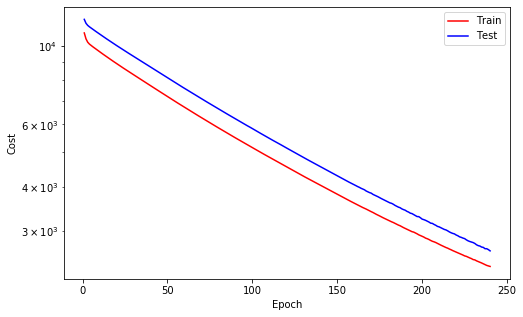



Epoch   241
Train_cost  = 2370.2975 | Test_cost  = 2622.7354 | 




Epoch   242
Train_cost  = 2357.8039 | Test_cost  = 2614.8984 | 




Epoch   243
Train_cost  = 2347.8681 | Test_cost  = 2598.6541 | 




Epoch   244
Train_cost  = 2335.3744 | Test_cost  = 2583.0764 | 




Epoch   245
Train_cost  = 2322.1614 | Test_cost  = 2572.6609 | 




Epoch   246
Train_cost  = 2313.1977 | Test_cost  = 2571.1348 | 




Epoch   247
Train_cost  = 2305.4180 | Test_cost  = 2543.1052 | 




Epoch   248
Train_cost  = 2291.1370 | Test_cost  = 2533.0669 | 




Epoch   249
Train_cost  = 2279.2667 | Test_cost  = 2518.9397 | 




Epoch   250
Train_cost  = 2266.3050 | Test_cost  = 2518.4470 | 




Epoch   251
Train_cost  = 2261.0398 | Test_cost  = 2496.5576 | 




Epoch   252
Train_cost  = 2248.9192 | Test_cost  = 2488.1338 | 




Epoch   253
Train_cost  = 2240.9349 | Test_cost  = 2468.3584 | 




Epoch   254
Train_cost  = 2227.2079 | Test_cost  = 2469.5005 | 
==> EarlyStop patience =  1 | Best test_cost: 2468.3584




Epoch   255
Train_cost  = 2220.9137 | Test_cost  = 2450.5117 | 




Epoch   256
Train_cost  = 2209.5701 | Test_cost  = 2442.0645 | 




Epoch   257
Train_cost  = 2201.6591 | Test_cost  = 2421.6035 | 




Epoch   258
Train_cost  = 2189.2962 | Test_cost  = 2417.0698 | 




Epoch   259
Train_cost  = 2179.8688 | Test_cost  = 2401.6228 | 




Epoch   260
Train_cost  = 2167.6212 | Test_cost  = 2394.9812 | 


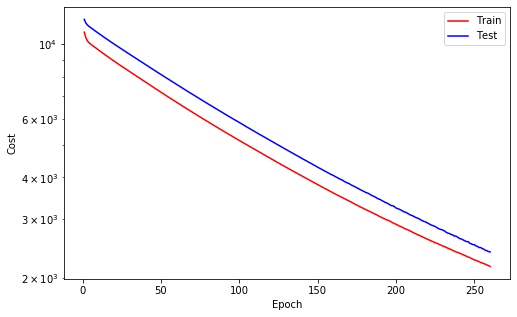



Epoch   261
Train_cost  = 2158.8461 | Test_cost  = 2377.7017 | 




Epoch   262
Train_cost  = 2147.8616 | Test_cost  = 2368.4048 | 




Epoch   263
Train_cost  = 2137.0592 | Test_cost  = 2358.9077 | 




Epoch   264
Train_cost  = 2128.4443 | Test_cost  = 2352.0955 | 




Epoch   265
Train_cost  = 2118.9589 | Test_cost  = 2343.2017 | 




Epoch   266
Train_cost  = 2112.2415 | Test_cost  = 2324.6267 | 




Epoch   267
Train_cost  = 2102.2131 | Test_cost  = 2315.9426 | 




Epoch   268
Train_cost  = 2096.6328 | Test_cost  = 2300.0981 | 




Epoch   269
Train_cost  = 2084.0555 | Test_cost  = 2300.8608 | 
==> EarlyStop patience =  1 | Best test_cost: 2300.0981




Epoch   270
Train_cost  = 2075.1002 | Test_cost  = 2287.9546 | 




Epoch   271
Train_cost  = 2067.8814 | Test_cost  = 2277.7366 | 




Epoch   272
Train_cost  = 2060.0676 | Test_cost  = 2257.6228 | 




Epoch   273
Train_cost  = 2051.3844 | Test_cost  = 2250.6047 | 




Epoch   274
Train_cost  = 2038.9286 | Test_cost  = 2245.5879 | 




Epoch   275
Train_cost  = 2030.7535 | Test_cost  = 2239.8730 | 




Epoch   276
Train_cost  = 2022.8614 | Test_cost  = 2220.8765 | 




Epoch   277
Train_cost  = 2014.4376 | Test_cost  = 2210.8779 | 




Epoch   278
Train_cost  = 2004.8038 | Test_cost  = 2202.8994 | 




Epoch   279
Train_cost  = 1994.8932 | Test_cost  = 2202.7971 | 




Epoch   280
Train_cost  = 1987.5764 | Test_cost  = 2180.8301 | 


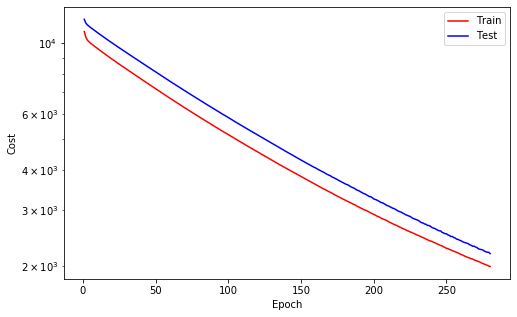



Epoch   281
Train_cost  = 1979.0237 | Test_cost  = 2174.2888 | 




Epoch   282
Train_cost  = 1970.4260 | Test_cost  = 2162.6907 | 




Epoch   283
Train_cost  = 1959.4932 | Test_cost  = 2163.9866 | 
==> EarlyStop patience =  1 | Best test_cost: 2162.6907




Epoch   284
Train_cost  = 1957.9060 | Test_cost  = 2149.2827 | 




Epoch   285
Train_cost  = 1949.1865 | Test_cost  = 2136.0850 | 




Epoch   286
Train_cost  = 1942.1376 | Test_cost  = 2122.9509 | 




Epoch   287
Train_cost  = 1930.2518 | Test_cost  = 2124.1692 | 
==> EarlyStop patience =  1 | Best test_cost: 2122.9509




Epoch   288
Train_cost  = 1921.6711 | Test_cost  = 2108.6028 | 




Epoch   289
Train_cost  = 1918.2194 | Test_cost  = 2096.4490 | 




Epoch   290
Train_cost  = 1906.1811 | Test_cost  = 2082.9473 | 




Epoch   291
Train_cost  = 1897.5874 | Test_cost  = 2084.7053 | 
==> EarlyStop patience =  1 | Best test_cost: 2082.9473




Epoch   292
Train_cost  = 1889.2028 | Test_cost  = 2074.1594 | 




Epoch   293
Train_cost  = 1882.4060 | Test_cost  = 2065.4773 | 




Epoch   294
Train_cost  = 1875.5113 | Test_cost  = 2054.4006 | 




Epoch   295
Train_cost  = 1866.8170 | Test_cost  = 2041.5139 | 




Epoch   296
Train_cost  = 1858.5841 | Test_cost  = 2039.8292 | 




Epoch   297
Train_cost  = 1848.8191 | Test_cost  = 2026.7888 | 




Epoch   298
Train_cost  = 1844.1100 | Test_cost  = 2019.3656 | 




Epoch   299
Train_cost  = 1834.4867 | Test_cost  = 2005.9336 | 




Epoch   300
Train_cost  = 1827.4138 | Test_cost  = 2001.2120 | 


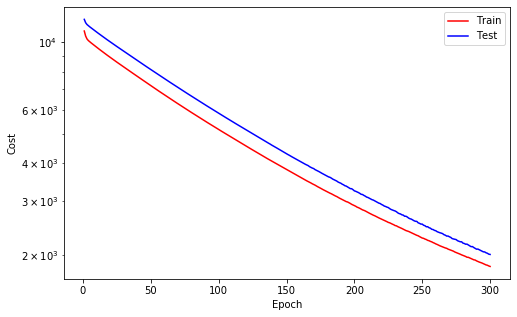



Epoch   301
Train_cost  = 1816.8171 | Test_cost  = 1996.5370 | 




Epoch   302
Train_cost  = 1809.5957 | Test_cost  = 1985.5792 | 




Epoch   303
Train_cost  = 1802.1817 | Test_cost  = 1974.5808 | 




Epoch   304
Train_cost  = 1794.9725 | Test_cost  = 1966.2130 | 




Epoch   305
Train_cost  = 1787.1373 | Test_cost  = 1960.8970 | 




Epoch   306
Train_cost  = 1779.4523 | Test_cost  = 1959.2943 | 




Epoch   307
Train_cost  = 1772.5302 | Test_cost  = 1949.0054 | 




Epoch   308
Train_cost  = 1767.4848 | Test_cost  = 1932.7048 | 




Epoch   309
Train_cost  = 1760.3574 | Test_cost  = 1925.7203 | 




Epoch   310
Train_cost  = 1755.2578 | Test_cost  = 1920.2334 | 




Epoch   311
Train_cost  = 1748.7480 | Test_cost  = 1922.7866 | 
==> EarlyStop patience =  1 | Best test_cost: 1920.2334




Epoch   312
Train_cost  = 1742.2070 | Test_cost  = 1908.9425 | 




Epoch   313
Train_cost  = 1737.3864 | Test_cost  = 1900.0415 | 




Epoch   314
Train_cost  = 1732.4228 | Test_cost  = 1875.1703 | 




Epoch   315
Train_cost  = 1726.4805 | Test_cost  = 1882.8501 | 
==> EarlyStop patience =  1 | Best test_cost: 1875.1703




Epoch   316
Train_cost  = 1716.3669 | Test_cost  = 1866.2664 | 




Epoch   317
Train_cost  = 1707.5294 | Test_cost  = 1871.4877 | 
==> EarlyStop patience =  1 | Best test_cost: 1866.2664




Epoch   318
Train_cost  = 1702.5257 | Test_cost  = 1846.7198 | 




Epoch   319
Train_cost  = 1695.5857 | Test_cost  = 1846.6133 | 




Epoch   320
Train_cost  = 1690.4656 | Test_cost  = 1842.0226 | 


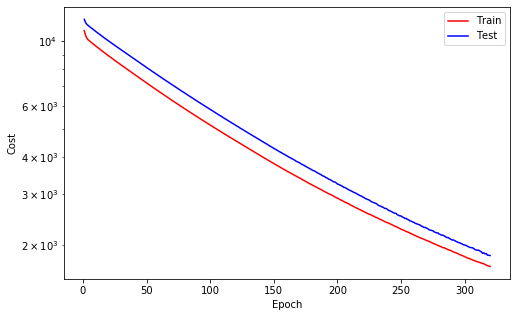



Epoch   321
Train_cost  = 1679.0518 | Test_cost  = 1832.7028 | 




Epoch   322
Train_cost  = 1675.2279 | Test_cost  = 1829.6206 | 




Epoch   323
Train_cost  = 1665.3212 | Test_cost  = 1811.6823 | 




Epoch   324
Train_cost  = 1663.3892 | Test_cost  = 1815.2085 | 
==> EarlyStop patience =  1 | Best test_cost: 1811.6823




Epoch   325
Train_cost  = 1653.7619 | Test_cost  = 1793.7810 | 




Epoch   326
Train_cost  = 1651.7934 | Test_cost  = 1809.9155 | 
==> EarlyStop patience =  1 | Best test_cost: 1793.7810




Epoch   327
Train_cost  = 1648.0977 | Test_cost  = 1783.0768 | 




Epoch   328
Train_cost  = 1643.8758 | Test_cost  = 1783.6279 | 
==> EarlyStop patience =  1 | Best test_cost: 1783.0768




Epoch   329
Train_cost  = 1635.1096 | Test_cost  = 1767.8458 | 




Epoch   330
Train_cost  = 1631.4668 | Test_cost  = 1755.5376 | 




Epoch   331
Train_cost  = 1616.6124 | Test_cost  = 1764.3710 | 
==> EarlyStop patience =  1 | Best test_cost: 1755.5376




Epoch   332
Train_cost  = 1610.1709 | Test_cost  = 1749.9750 | 




Epoch   333
Train_cost  = 1603.2225 | Test_cost  = 1755.1765 | 
==> EarlyStop patience =  1 | Best test_cost: 1749.9750




Epoch   334
Train_cost  = 1599.9457 | Test_cost  = 1727.7635 | 




Epoch   335
Train_cost  = 1593.0145 | Test_cost  = 1737.7338 | 
==> EarlyStop patience =  1 | Best test_cost: 1727.7635




Epoch   336
Train_cost  = 1585.8371 | Test_cost  = 1723.4795 | 




Epoch   337
Train_cost  = 1576.5845 | Test_cost  = 1721.8470 | 




Epoch   338
Train_cost  = 1573.1058 | Test_cost  = 1708.4036 | 




Epoch   339
Train_cost  = 1564.6245 | Test_cost  = 1704.0695 | 




Epoch   340
Train_cost  = 1563.1904 | Test_cost  = 1697.3085 | 


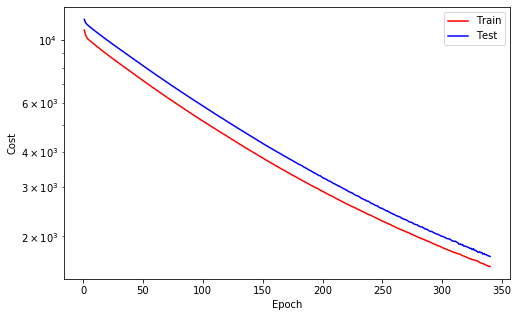



Epoch   341
Train_cost  = 1551.0433 | Test_cost  = 1698.4189 | 
==> EarlyStop patience =  1 | Best test_cost: 1697.3085




Epoch   342
Train_cost  = 1549.8111 | Test_cost  = 1681.2314 | 




Epoch   343
Train_cost  = 1539.6627 | Test_cost  = 1684.0598 | 
==> EarlyStop patience =  1 | Best test_cost: 1681.2314




Epoch   344
Train_cost  = 1539.6044 | Test_cost  = 1660.5020 | 




Epoch   345
Train_cost  = 1529.3605 | Test_cost  = 1671.8008 | 
==> EarlyStop patience =  1 | Best test_cost: 1660.5020




Epoch   346
Train_cost  = 1525.7974 | Test_cost  = 1651.6886 | 




Epoch   347
Train_cost  = 1516.1547 | Test_cost  = 1665.9821 | 
==> EarlyStop patience =  1 | Best test_cost: 1651.6886




Epoch   348
Train_cost  = 1517.4066 | Test_cost  = 1635.7922 | 




Epoch   349
Train_cost  = 1507.7487 | Test_cost  = 1651.8463 | 
==> EarlyStop patience =  1 | Best test_cost: 1635.7922




Epoch   350
Train_cost  = 1508.5101 | Test_cost  = 1620.2656 | 




Epoch   351
Train_cost  = 1496.5491 | Test_cost  = 1632.9249 | 
==> EarlyStop patience =  1 | Best test_cost: 1620.2656




Epoch   352
Train_cost  = 1494.9776 | Test_cost  = 1613.4713 | 




Epoch   353
Train_cost  = 1485.9257 | Test_cost  = 1623.8936 | 
==> EarlyStop patience =  1 | Best test_cost: 1613.4713




Epoch   354
Train_cost  = 1482.6253 | Test_cost  = 1600.5142 | 




Epoch   355
Train_cost  = 1475.3548 | Test_cost  = 1607.6545 | 
==> EarlyStop patience =  1 | Best test_cost: 1600.5142




Epoch   356
Train_cost  = 1470.9039 | Test_cost  = 1588.7107 | 




Epoch   357
Train_cost  = 1466.9430 | Test_cost  = 1591.4604 | 
==> EarlyStop patience =  1 | Best test_cost: 1588.7107




Epoch   358
Train_cost  = 1458.6938 | Test_cost  = 1582.7290 | 




Epoch   359
Train_cost  = 1452.9950 | Test_cost  = 1582.9442 | 
==> EarlyStop patience =  1 | Best test_cost: 1582.7290




Epoch   360
Train_cost  = 1448.2531 | Test_cost  = 1574.2609 | 


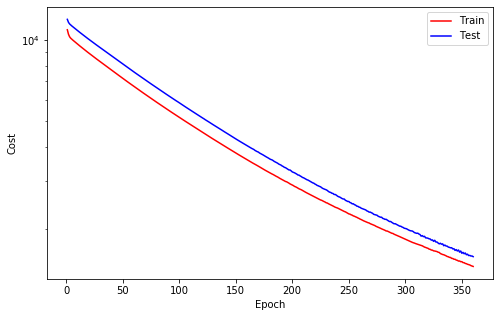



Epoch   361
Train_cost  = 1442.7986 | Test_cost  = 1563.3352 | 




Epoch   362
Train_cost  = 1436.4930 | Test_cost  = 1561.1548 | 




Epoch   363
Train_cost  = 1434.3155 | Test_cost  = 1548.7769 | 




Epoch   364
Train_cost  = 1427.2669 | Test_cost  = 1550.4575 | 
==> EarlyStop patience =  1 | Best test_cost: 1548.7769




Epoch   365
Train_cost  = 1418.9319 | Test_cost  = 1553.1427 | 
==> EarlyStop patience =  2 | Best test_cost: 1548.7769




Epoch   366
Train_cost  = 1419.7008 | Test_cost  = 1540.7656 | 




Epoch   367
Train_cost  = 1409.9301 | Test_cost  = 1525.5789 | 




Epoch   368
Train_cost  = 1407.6630 | Test_cost  = 1518.1655 | 




Epoch   369
Train_cost  = 1400.4536 | Test_cost  = 1518.8773 | 
==> EarlyStop patience =  1 | Best test_cost: 1518.1655




Epoch   370
Train_cost  = 1393.8308 | Test_cost  = 1522.9767 | 
==> EarlyStop patience =  2 | Best test_cost: 1518.1655




Epoch   371
Train_cost  = 1389.4848 | Test_cost  = 1506.6174 | 




Epoch   372
Train_cost  = 1380.6596 | Test_cost  = 1497.7489 | 




Epoch   373
Train_cost  = 1378.2817 | Test_cost  = 1499.1229 | 
==> EarlyStop patience =  1 | Best test_cost: 1497.7489




Epoch   374
Train_cost  = 1370.3687 | Test_cost  = 1499.5381 | 
==> EarlyStop patience =  2 | Best test_cost: 1497.7489




Epoch   375
Train_cost  = 1367.7849 | Test_cost  = 1492.2102 | 




Epoch   376
Train_cost  = 1362.7660 | Test_cost  = 1474.5165 | 




Epoch   377
Train_cost  = 1357.5847 | Test_cost  = 1473.5559 | 




Epoch   378
Train_cost  = 1351.6789 | Test_cost  = 1479.2183 | 
==> EarlyStop patience =  1 | Best test_cost: 1473.5559




Epoch   379
Train_cost  = 1345.9410 | Test_cost  = 1469.1761 | 




Epoch   380
Train_cost  = 1341.3136 | Test_cost  = 1453.9520 | 


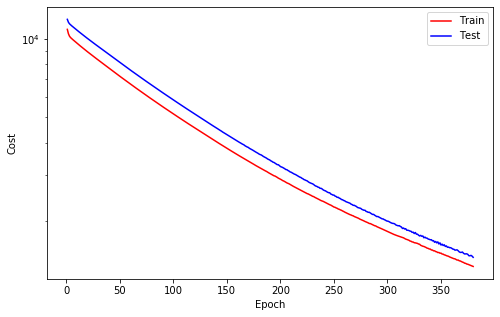



Epoch   381
Train_cost  = 1334.5843 | Test_cost  = 1452.6433 | 




Epoch   382
Train_cost  = 1329.2708 | Test_cost  = 1457.8315 | 
==> EarlyStop patience =  1 | Best test_cost: 1452.6433




Epoch   383
Train_cost  = 1325.5657 | Test_cost  = 1445.1537 | 




Epoch   384
Train_cost  = 1317.5383 | Test_cost  = 1442.0250 | 




Epoch   385
Train_cost  = 1316.0826 | Test_cost  = 1425.7430 | 




Epoch   386
Train_cost  = 1307.9728 | Test_cost  = 1439.9199 | 
==> EarlyStop patience =  1 | Best test_cost: 1425.7430




Epoch   387
Train_cost  = 1304.9447 | Test_cost  = 1429.0859 | 
==> EarlyStop patience =  2 | Best test_cost: 1425.7430




Epoch   388
Train_cost  = 1299.3398 | Test_cost  = 1423.7609 | 




Epoch   389
Train_cost  = 1293.9876 | Test_cost  = 1416.7700 | 




Epoch   390
Train_cost  = 1291.1820 | Test_cost  = 1410.2886 | 




Epoch   391
Train_cost  = 1283.0496 | Test_cost  = 1418.7366 | 
==> EarlyStop patience =  1 | Best test_cost: 1410.2886




Epoch   392
Train_cost  = 1282.5915 | Test_cost  = 1403.5850 | 




Epoch   393
Train_cost  = 1276.0236 | Test_cost  = 1402.7975 | 




Epoch   394
Train_cost  = 1273.1286 | Test_cost  = 1388.6755 | 




Epoch   395
Train_cost  = 1270.4097 | Test_cost  = 1394.1919 | 
==> EarlyStop patience =  1 | Best test_cost: 1388.6755




Epoch   396
Train_cost  = 1261.6087 | Test_cost  = 1388.7871 | 
==> EarlyStop patience =  2 | Best test_cost: 1388.6755




Epoch   397
Train_cost  = 1260.8779 | Test_cost  = 1383.7782 | 




Epoch   398
Train_cost  = 1250.8026 | Test_cost  = 1370.5958 | 




Epoch   399
Train_cost  = 1249.3806 | Test_cost  = 1368.0255 | 




Epoch   400
Train_cost  = 1243.5713 | Test_cost  = 1361.2842 | 


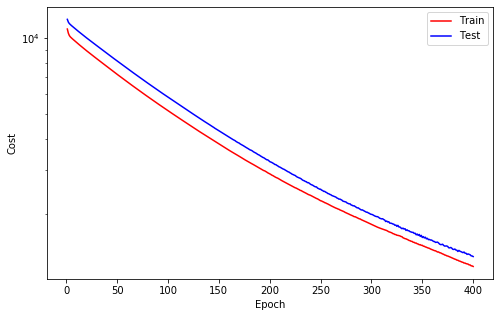



Epoch   401
Train_cost  = 1240.0791 | Test_cost  = 1375.2700 | 
==> EarlyStop patience =  1 | Best test_cost: 1361.2842




Epoch   402
Train_cost  = 1237.2153 | Test_cost  = 1350.6458 | 




Epoch   403
Train_cost  = 1234.6256 | Test_cost  = 1362.8286 | 
==> EarlyStop patience =  1 | Best test_cost: 1350.6458




Epoch   404
Train_cost  = 1233.9411 | Test_cost  = 1337.8474 | 




Epoch   405
Train_cost  = 1237.2519 | Test_cost  = 1355.0302 | 
==> EarlyStop patience =  1 | Best test_cost: 1337.8474




Epoch   406
Train_cost  = 1229.6241 | Test_cost  = 1332.6163 | 




Epoch   407
Train_cost  = 1219.9065 | Test_cost  = 1330.9688 | 




Epoch   408
Train_cost  = 1212.0081 | Test_cost  = 1326.2197 | 




Epoch   409
Train_cost  = 1205.6618 | Test_cost  = 1318.2970 | 




Epoch   410
Train_cost  = 1201.1967 | Test_cost  = 1322.3214 | 
==> EarlyStop patience =  1 | Best test_cost: 1318.2970




Epoch   411
Train_cost  = 1192.2995 | Test_cost  = 1319.3668 | 
==> EarlyStop patience =  2 | Best test_cost: 1318.2970




Epoch   412
Train_cost  = 1190.8706 | Test_cost  = 1307.1292 | 




Epoch   413
Train_cost  = 1187.1667 | Test_cost  = 1302.8458 | 




Epoch   414
Train_cost  = 1182.2884 | Test_cost  = 1300.3883 | 




Epoch   415
Train_cost  = 1174.7897 | Test_cost  = 1291.8344 | 




Epoch   416
Train_cost  = 1166.4886 | Test_cost  = 1303.0164 | 
==> EarlyStop patience =  1 | Best test_cost: 1291.8344




Epoch   417
Train_cost  = 1163.8350 | Test_cost  = 1287.0913 | 




Epoch   418
Train_cost  = 1157.8239 | Test_cost  = 1288.6802 | 
==> EarlyStop patience =  1 | Best test_cost: 1287.0913




Epoch   419
Train_cost  = 1156.4634 | Test_cost  = 1281.5597 | 




Epoch   420
Train_cost  = 1155.0217 | Test_cost  = 1273.4203 | 


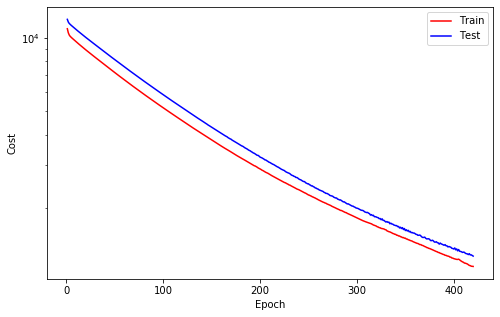



Epoch   421
Train_cost  = 1148.4395 | Test_cost  = 1284.0768 | 
==> EarlyStop patience =  1 | Best test_cost: 1273.4203




Epoch   422
Train_cost  = 1146.4938 | Test_cost  = 1270.5651 | 




Epoch   423
Train_cost  = 1143.3639 | Test_cost  = 1281.5913 | 
==> EarlyStop patience =  1 | Best test_cost: 1270.5651




Epoch   424
Train_cost  = 1149.1383 | Test_cost  = 1254.1361 | 




Epoch   425
Train_cost  = 1143.6164 | Test_cost  = 1256.0792 | 
==> EarlyStop patience =  1 | Best test_cost: 1254.1361




Epoch   426
Train_cost  = 1141.9029 | Test_cost  = 1252.9796 | 




Epoch   427
Train_cost  = 1132.2038 | Test_cost  = 1260.7213 | 
==> EarlyStop patience =  1 | Best test_cost: 1252.9796




Epoch   428
Train_cost  = 1138.0476 | Test_cost  = 1260.6608 | 
==> EarlyStop patience =  2 | Best test_cost: 1252.9796




Epoch   429
Train_cost  = 1134.4210 | Test_cost  = 1232.8373 | 




Epoch   430
Train_cost  = 1134.5170 | Test_cost  = 1238.6781 | 
==> EarlyStop patience =  1 | Best test_cost: 1232.8373




Epoch   431
Train_cost  = 1121.0212 | Test_cost  = 1237.1553 | 
==> EarlyStop patience =  2 | Best test_cost: 1232.8373




Epoch   432
Train_cost  = 1116.9010 | Test_cost  = 1231.3124 | 




Epoch   433
Train_cost  = 1108.9090 | Test_cost  = 1217.0238 | 




Epoch   434
Train_cost  = 1106.4926 | Test_cost  = 1221.2200 | 
==> EarlyStop patience =  1 | Best test_cost: 1217.0238




Epoch   435
Train_cost  = 1098.9824 | Test_cost  = 1214.1149 | 




Epoch   436
Train_cost  = 1088.7323 | Test_cost  = 1209.6154 | 




Epoch   437
Train_cost  = 1086.6305 | Test_cost  = 1201.3571 | 




Epoch   438
Train_cost  = 1076.5417 | Test_cost  = 1216.2943 | 
==> EarlyStop patience =  1 | Best test_cost: 1201.3571




Epoch   439
Train_cost  = 1076.0919 | Test_cost  = 1200.4240 | 




Epoch   440
Train_cost  = 1069.5003 | Test_cost  = 1192.9907 | 


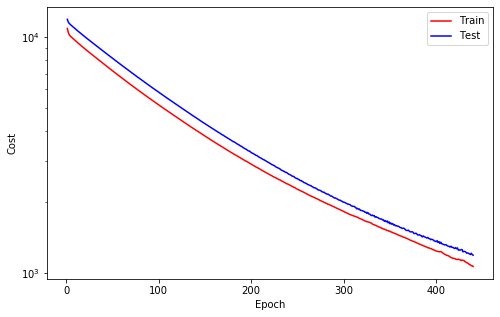



Epoch   441
Train_cost  = 1064.5963 | Test_cost  = 1198.1068 | 
==> EarlyStop patience =  1 | Best test_cost: 1192.9907




Epoch   442
Train_cost  = 1059.7515 | Test_cost  = 1194.3402 | 
==> EarlyStop patience =  2 | Best test_cost: 1192.9907




Epoch   443
Train_cost  = 1053.6139 | Test_cost  = 1184.0924 | 




Epoch   444
Train_cost  = 1052.8522 | Test_cost  = 1180.7192 | 




Epoch   445
Train_cost  = 1046.3049 | Test_cost  = 1189.0875 | 
==> EarlyStop patience =  1 | Best test_cost: 1180.7192




Epoch   446
Train_cost  = 1044.1904 | Test_cost  = 1185.2009 | 
==> EarlyStop patience =  2 | Best test_cost: 1180.7192




Epoch   447
Train_cost  = 1038.9828 | Test_cost  = 1170.5072 | 




Epoch   448
Train_cost  = 1035.5101 | Test_cost  = 1170.5522 | 
==> EarlyStop patience =  1 | Best test_cost: 1170.5072




Epoch   449
Train_cost  = 1032.5442 | Test_cost  = 1172.4194 | 
==> EarlyStop patience =  2 | Best test_cost: 1170.5072




Epoch   450
Train_cost  = 1027.7974 | Test_cost  = 1175.0540 | 
==> EarlyStop patience =  3 | Best test_cost: 1170.5072




Epoch   451
Train_cost  = 1025.6597 | Test_cost  = 1162.6136 | 




Epoch   452
Train_cost  = 1021.9066 | Test_cost  = 1154.4253 | 




Epoch   453
Train_cost  = 1017.4754 | Test_cost  = 1160.1473 | 
==> EarlyStop patience =  1 | Best test_cost: 1154.4253




Epoch   454
Train_cost  = 1015.5853 | Test_cost  = 1159.9598 | 
==> EarlyStop patience =  2 | Best test_cost: 1154.4253




Epoch   455
Train_cost  = 1011.5525 | Test_cost  = 1157.3214 | 
==> EarlyStop patience =  3 | Best test_cost: 1154.4253




Epoch   456
Train_cost  = 1012.8873 | Test_cost  = 1145.9697 | 




Epoch   457
Train_cost  = 1008.6765 | Test_cost  = 1139.6599 | 




Epoch   458
Train_cost  = 1003.8831 | Test_cost  = 1140.1195 | 
==> EarlyStop patience =  1 | Best test_cost: 1139.6599




Epoch   459
Train_cost  = 998.7660 | Test_cost  = 1143.9875 | 
==> EarlyStop patience =  2 | Best test_cost: 1139.6599




Epoch   460
Train_cost  = 998.7714 | Test_cost  = 1137.7970 | 


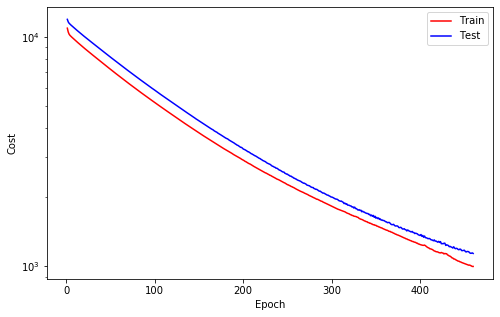



Epoch   461
Train_cost  = 1000.7661 | Test_cost  = 1126.6609 | 




Epoch   462
Train_cost  = 999.0596 | Test_cost  = 1131.3560 | 
==> EarlyStop patience =  1 | Best test_cost: 1126.6609




Epoch   463
Train_cost  = 999.3331 | Test_cost  = 1122.4492 | 




Epoch   464
Train_cost  = 995.3438 | Test_cost  = 1138.7178 | 
==> EarlyStop patience =  1 | Best test_cost: 1122.4492




Epoch   465
Train_cost  = 999.5606 | Test_cost  = 1109.7021 | 




Epoch   466
Train_cost  = 981.0934 | Test_cost  = 1108.7611 | 




Epoch   467
Train_cost  = 976.9266 | Test_cost  = 1109.6117 | 
==> EarlyStop patience =  1 | Best test_cost: 1108.7611




Epoch   468
Train_cost  = 967.6848 | Test_cost  = 1122.0730 | 
==> EarlyStop patience =  2 | Best test_cost: 1108.7611




Epoch   469
Train_cost  = 968.0207 | Test_cost  = 1112.6211 | 
==> EarlyStop patience =  3 | Best test_cost: 1108.7611




Epoch   470
Train_cost  = 962.2475 | Test_cost  = 1097.7812 | 




Epoch   471
Train_cost  = 965.2387 | Test_cost  = 1097.8789 | 
==> EarlyStop patience =  1 | Best test_cost: 1097.7812




Epoch   472
Train_cost  = 965.6941 | Test_cost  = 1112.3164 | 
==> EarlyStop patience =  2 | Best test_cost: 1097.7812




Epoch   473
Train_cost  = 962.1787 | Test_cost  = 1112.4019 | 
==> EarlyStop patience =  3 | Best test_cost: 1097.7812




Epoch   474
Train_cost  = 956.2139 | Test_cost  = 1090.8551 | 




Epoch   475
Train_cost  = 955.6068 | Test_cost  = 1082.4407 | 




Epoch   476
Train_cost  = 950.4025 | Test_cost  = 1103.3069 | 
==> EarlyStop patience =  1 | Best test_cost: 1082.4407




Epoch   477
Train_cost  = 952.3130 | Test_cost  = 1093.4752 | 
==> EarlyStop patience =  2 | Best test_cost: 1082.4407




Epoch   478
Train_cost  = 938.0500 | Test_cost  = 1082.8605 | 
==> EarlyStop patience =  3 | Best test_cost: 1082.4407




Epoch   479
Train_cost  = 938.6441 | Test_cost  = 1079.2648 | 




Epoch   480
Train_cost  = 931.1346 | Test_cost  = 1086.1576 | 


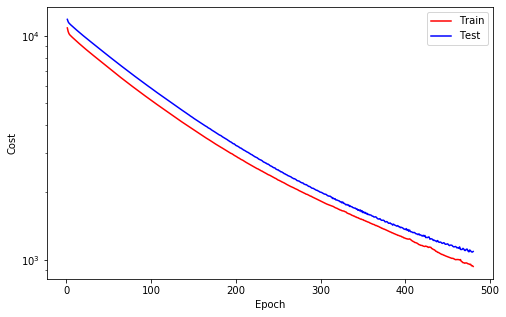

==> EarlyStop patience =  1 | Best test_cost: 1079.2648




Epoch   481
Train_cost  = 927.3860 | Test_cost  = 1073.1101 | 




Epoch   482
Train_cost  = 923.0862 | Test_cost  = 1070.5106 | 




Epoch   483
Train_cost  = 915.3915 | Test_cost  = 1084.1564 | 
==> EarlyStop patience =  1 | Best test_cost: 1070.5106




Epoch   484
Train_cost  = 915.8727 | Test_cost  = 1062.6432 | 




Epoch   485
Train_cost  = 909.0998 | Test_cost  = 1066.8473 | 
==> EarlyStop patience =  1 | Best test_cost: 1062.6432




Epoch   486
Train_cost  = 905.5781 | Test_cost  = 1068.2113 | 
==> EarlyStop patience =  2 | Best test_cost: 1062.6432




Epoch   487
Train_cost  = 902.4991 | Test_cost  = 1075.1091 | 
==> EarlyStop patience =  3 | Best test_cost: 1062.6432




Epoch   488
Train_cost  = 899.1098 | Test_cost  = 1056.6449 | 




Epoch   489
Train_cost  = 897.6728 | Test_cost  = 1061.4318 | 
==> EarlyStop patience =  1 | Best test_cost: 1056.6449




Epoch   490
Train_cost  = 895.1574 | Test_cost  = 1065.3846 | 
==> EarlyStop patience =  2 | Best test_cost: 1056.6449




Epoch   491
Train_cost  = 895.0672 | Test_cost  = 1063.6425 | 
==> EarlyStop patience =  3 | Best test_cost: 1056.6449




Epoch   492
Train_cost  = 891.8681 | Test_cost  = 1050.1652 | 




Epoch   493
Train_cost  = 896.2280 | Test_cost  = 1052.4930 | 
==> EarlyStop patience =  1 | Best test_cost: 1050.1652




Epoch   494
Train_cost  = 901.1759 | Test_cost  = 1054.1769 | 
==> EarlyStop patience =  2 | Best test_cost: 1050.1652




Epoch   495
Train_cost  = 899.8741 | Test_cost  = 1055.8527 | 
==> EarlyStop patience =  3 | Best test_cost: 1050.1652




Epoch   496
Train_cost  = 900.5228 | Test_cost  = 1052.0664 | 
==> EarlyStop patience =  4 | Best test_cost: 1050.1652




Epoch   497
Train_cost  = 893.9913 | Test_cost  = 1029.8403 | 




Epoch   498
Train_cost  = 894.8141 | Test_cost  = 1044.1147 | 
==> EarlyStop patience =  1 | Best test_cost: 1029.8403




Epoch   499
Train_cost  = 888.0164 | Test_cost  = 1039.0037 | 
==> EarlyStop patience =  2 | Best test_cost: 1029.8403




Epoch   500
Train_cost  = 879.1810 | Test_cost  = 1039.6787 | 


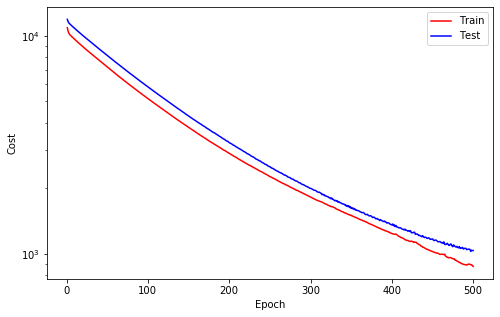

==> EarlyStop patience =  3 | Best test_cost: 1029.8403




Epoch   501
Train_cost  = 873.0755 | Test_cost  = 1023.6548 | 




Epoch   502
Train_cost  = 866.0283 | Test_cost  = 1030.2092 | 
==> EarlyStop patience =  1 | Best test_cost: 1023.6548




Epoch   503
Train_cost  = 863.4735 | Test_cost  = 1033.6816 | 
==> EarlyStop patience =  2 | Best test_cost: 1023.6548




Epoch   504
Train_cost  = 860.6176 | Test_cost  = 1030.6757 | 
==> EarlyStop patience =  3 | Best test_cost: 1023.6548




Epoch   505
Train_cost  = 856.0032 | Test_cost  = 1017.0146 | 




Epoch   506
Train_cost  = 852.7950 | Test_cost  = 1024.9170 | 
==> EarlyStop patience =  1 | Best test_cost: 1017.0146




Epoch   507
Train_cost  = 848.5014 | Test_cost  = 1022.1142 | 
==> EarlyStop patience =  2 | Best test_cost: 1017.0146




Epoch   508
Train_cost  = 847.1848 | Test_cost  = 1024.1946 | 
==> EarlyStop patience =  3 | Best test_cost: 1017.0146




Epoch   509
Train_cost  = 842.0159 | Test_cost  = 1006.7129 | 




Epoch   510
Train_cost  = 839.1876 | Test_cost  = 1020.2064 | 
==> EarlyStop patience =  1 | Best test_cost: 1006.7129




Epoch   511
Train_cost  = 835.9002 | Test_cost  = 1023.1793 | 
==> EarlyStop patience =  2 | Best test_cost: 1006.7129




Epoch   512
Train_cost  = 835.3725 | Test_cost  = 1021.4465 | 
==> EarlyStop patience =  3 | Best test_cost: 1006.7129




Epoch   513
Train_cost  = 830.2826 | Test_cost  = 1003.7717 | 




Epoch   514
Train_cost  = 827.9121 | Test_cost  = 1005.1064 | 
==> EarlyStop patience =  1 | Best test_cost: 1003.7717




Epoch   515
Train_cost  = 826.0711 | Test_cost  = 1017.3011 | 
==> EarlyStop patience =  2 | Best test_cost: 1003.7717




Epoch   516
Train_cost  = 825.8565 | Test_cost  = 1027.5726 | 
==> EarlyStop patience =  3 | Best test_cost: 1003.7717




Epoch   517
Train_cost  = 825.4448 | Test_cost  = 1003.1983 | 




Epoch   518
Train_cost  = 818.7744 | Test_cost  = 996.9109 | 




Epoch   519
Train_cost  = 822.3718 | Test_cost  = 1006.4551 | 
==> EarlyStop patience =  1 | Best test_cost: 996.9109




Epoch   520
Train_cost  = 818.6612 | Test_cost  = 1028.9152 | 


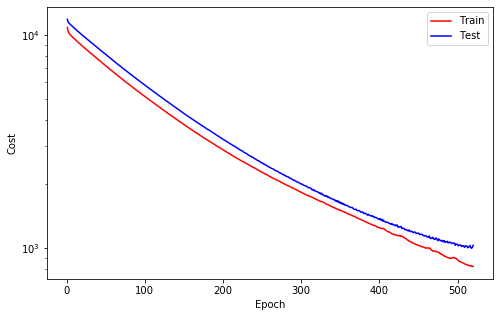

==> EarlyStop patience =  2 | Best test_cost: 996.9109




Epoch   521
Train_cost  = 820.6775 | Test_cost  = 998.1652 | 
==> EarlyStop patience =  3 | Best test_cost: 996.9109




Epoch   522
Train_cost  = 812.7617 | Test_cost  = 995.1750 | 




Epoch   523
Train_cost  = 816.6811 | Test_cost  = 998.1309 | 
==> EarlyStop patience =  1 | Best test_cost: 995.1750




Epoch   524
Train_cost  = 814.8356 | Test_cost  = 1014.3411 | 
==> EarlyStop patience =  2 | Best test_cost: 995.1750




Epoch   525
Train_cost  = 810.4164 | Test_cost  = 984.3208 | 




Epoch   526
Train_cost  = 806.9194 | Test_cost  = 994.3961 | 
==> EarlyStop patience =  1 | Best test_cost: 984.3208




Epoch   527
Train_cost  = 801.3238 | Test_cost  = 1001.4162 | 
==> EarlyStop patience =  2 | Best test_cost: 984.3208




Epoch   528
Train_cost  = 805.6775 | Test_cost  = 993.9839 | 
==> EarlyStop patience =  3 | Best test_cost: 984.3208




Epoch   529
Train_cost  = 803.0142 | Test_cost  = 975.7369 | 




Epoch   530
Train_cost  = 799.6227 | Test_cost  = 997.1619 | 
==> EarlyStop patience =  1 | Best test_cost: 975.7369




Epoch   531
Train_cost  = 797.4348 | Test_cost  = 983.8995 | 
==> EarlyStop patience =  2 | Best test_cost: 975.7369




Epoch   532
Train_cost  = 788.7615 | Test_cost  = 983.2609 | 
==> EarlyStop patience =  3 | Best test_cost: 975.7369




Epoch   533
Train_cost  = 788.0758 | Test_cost  = 986.2803 | 
==> EarlyStop patience =  4 | Best test_cost: 975.7369




Epoch   534
Train_cost  = 785.5622 | Test_cost  = 981.8682 | 
==> EarlyStop patience =  5 | Best test_cost: 975.7369
==> Execute Early Stopping at epoch: 534 | Best test_cost: 975.7369
==> Best model is saved at model


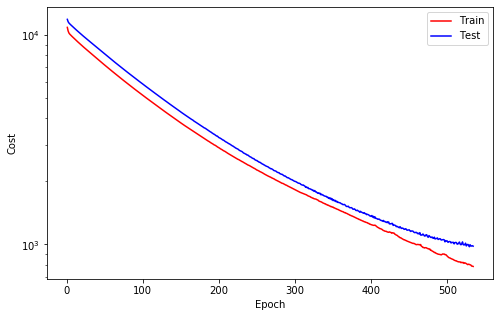

In [16]:
while True :
    train_cost= loop_fn("train",train_set,trainloader,model,criterion,optimizer,device)
    with torch.no_grad():
        test_cost= loop_fn("test",test_set,testloader,model,criterion,optimizer,device)

    callback.log(train_cost, test_cost)


    callback.save_checkpoint()


    callback.cost_runtime_plotting()



    if callback.early_stopping(model, monitor='test_cost'):
        callback.plot_cost()
        break

In [17]:
from luwiji.rnn import illustration

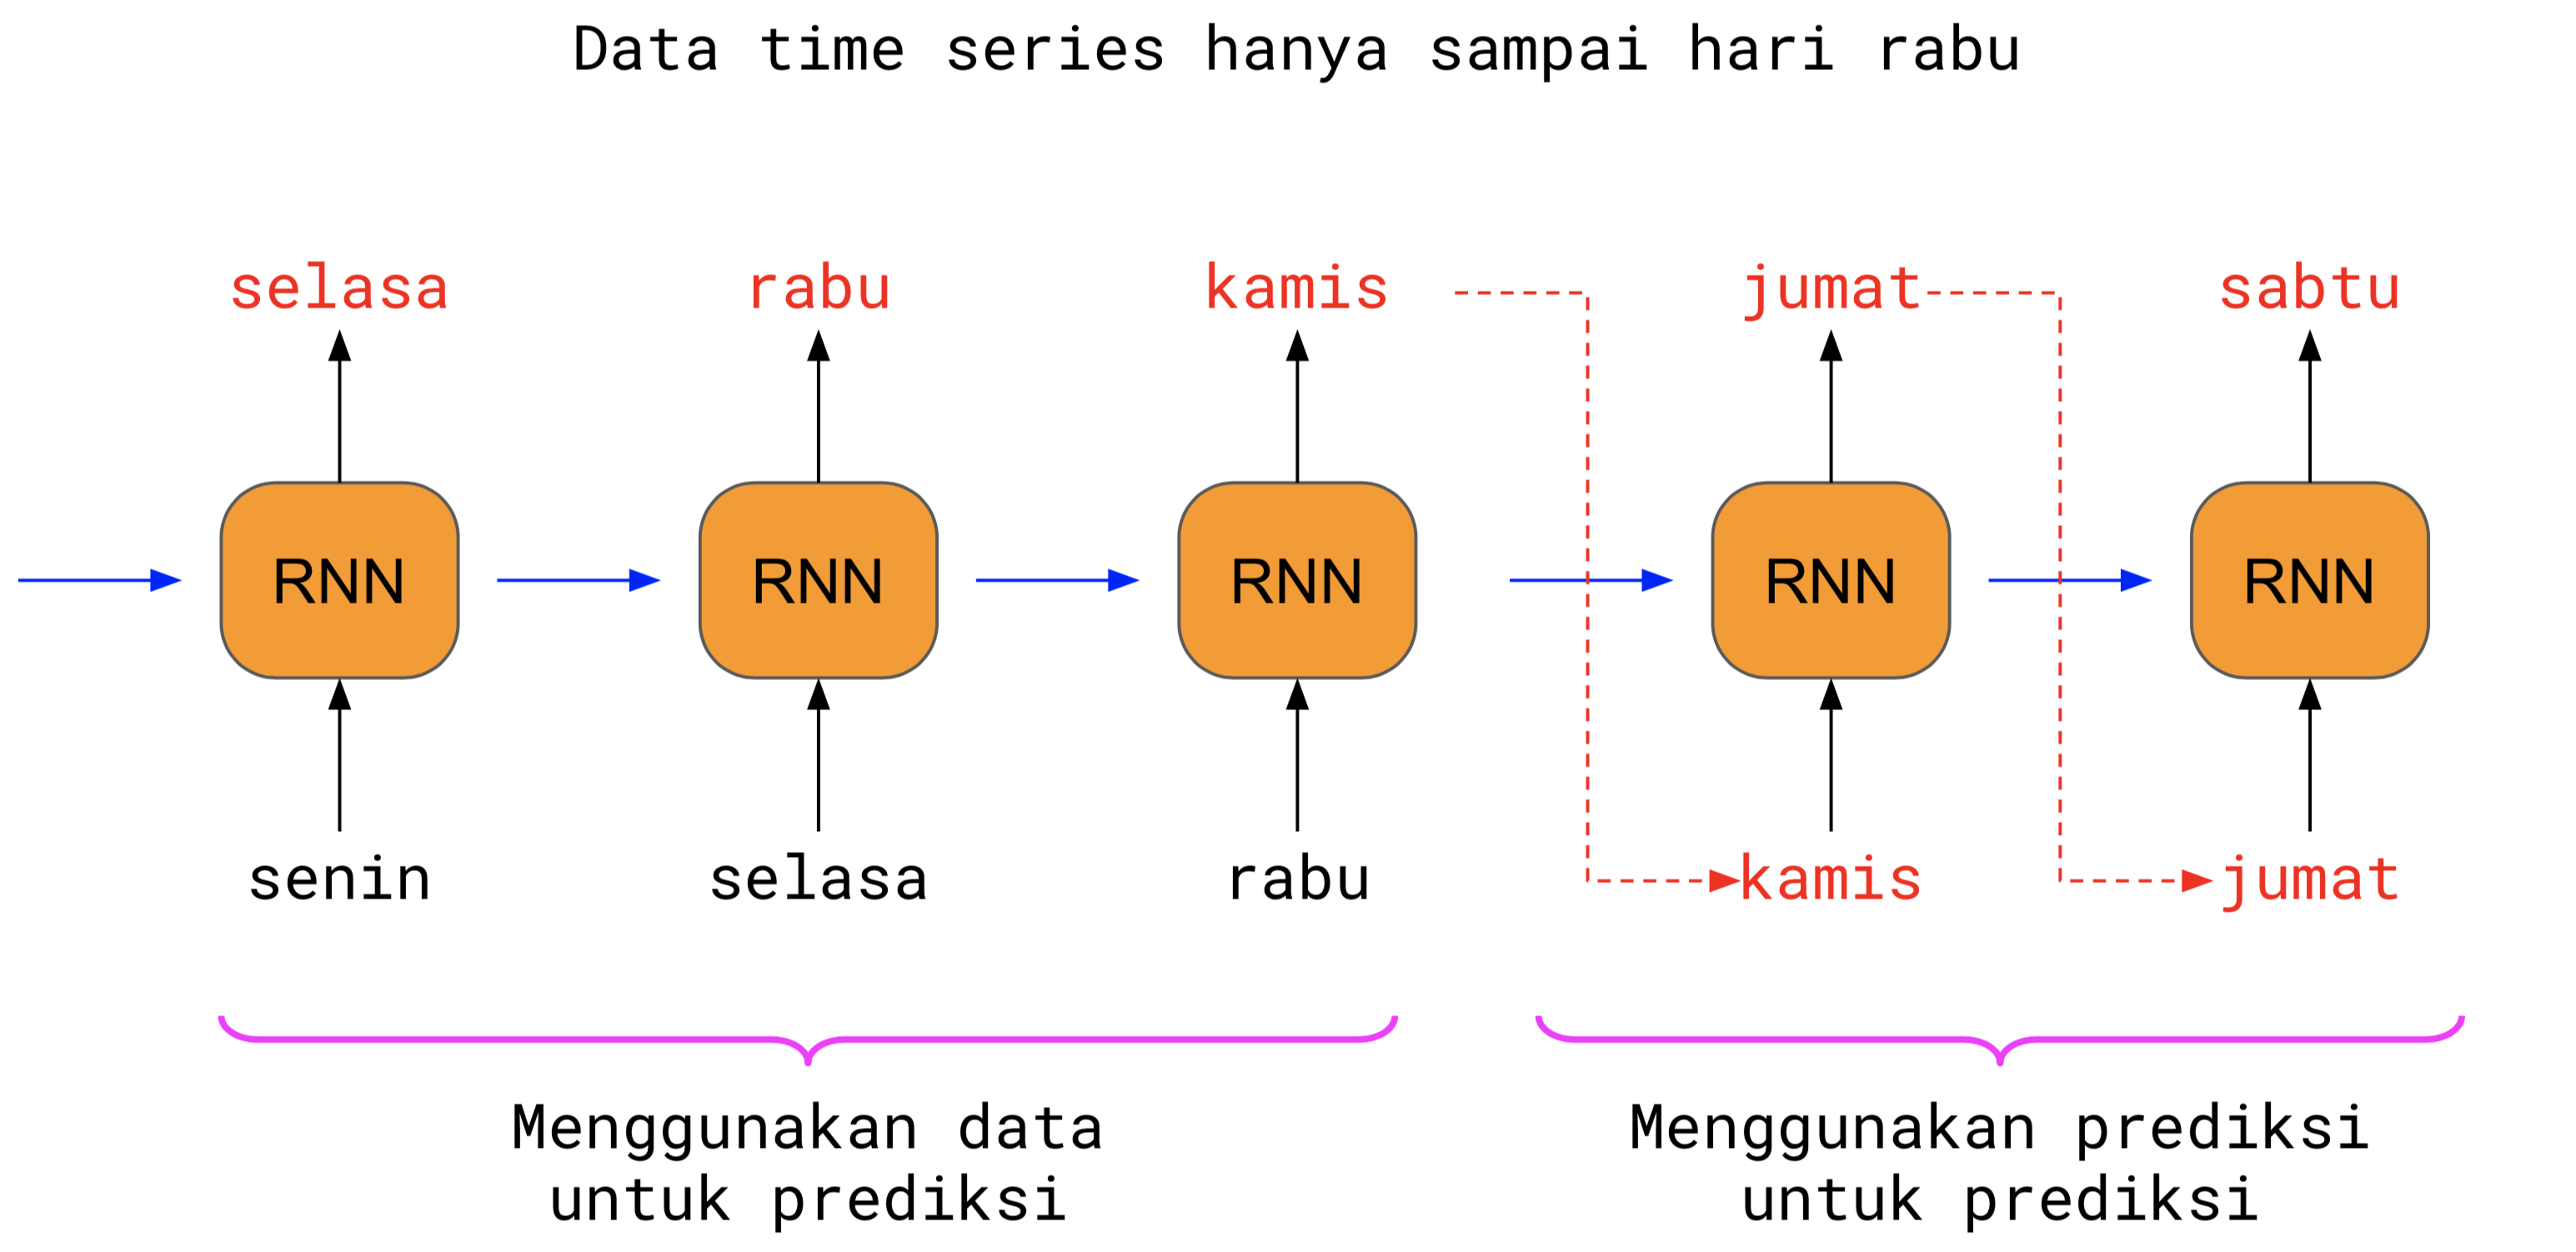

In [18]:
illustration.forecast

forcast untuk data time series itu sangat susah untuk diwujudkan dalam memprediksi dalam jangka panjang, karna apa? karna coba kita pahami illustrasi diatas, dimana pada saat training (menggunakan data untuk prediksi) model kita menggunakan data hari senin untuk memprediksi data hari selasa yang mana data hari selasa kita udah ada dalam dataset training kita, maka nya machine dapat memprediksi data yang ada (ya karna dia update weight, backprop, dll), tapi coba kita telaah lebih lanjut kalau misal nya kita hanya punya data yang dipelajari sampe hari rabu, kita coba untuk menggunakan insight dari data hari seni - rabu itu untuk memprediksi hari kamis dan selanjut nya, maka secara logika model machine kita akan kesusahan atau memiliki error prediksi yang tinggi, karna apa? karna informasi dari data data lalu (senin - rabu) itu gak terlalu bermakna, logika nya gini deh "kalau saya tau suhu di hari rabu, apakah saya bisa tau suhu di hari kamis? kemungkinan besar kita akan salah memprediksi nya" karna apa? karna informasi dari kita hanya mempelajari data data sebelum nya belum menjamin dapat memprediksi data data dikemudian hari selama nya. 
* maka dari itu kita perlu membuat data kita lebih bermakna, seperti kita bagi data misal nya berdasarkan quarter dalam satu tahun, maka itu setidak nya memberikan pola baru kepada machine dalam mempelajari pola.
* menggunakan metode pengembangan dari Recurrent Neural Network juga bisa menjadi solusi nya

In [19]:
from utils import data4pred,pred4pred

In [20]:
train_forecast_set = TimeSeriesDataset(ts_train,"Monthly_Mean_Sunspot",1)
trainforcastloader= DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test,"Monthly_Mean_Sunspot",1)
testforcastloader= DataLoader(test_forecast_set)



(N, S, F): (2611, 1, 1)
Note: last 0 data excluded

(N, S, F): (652, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'test')

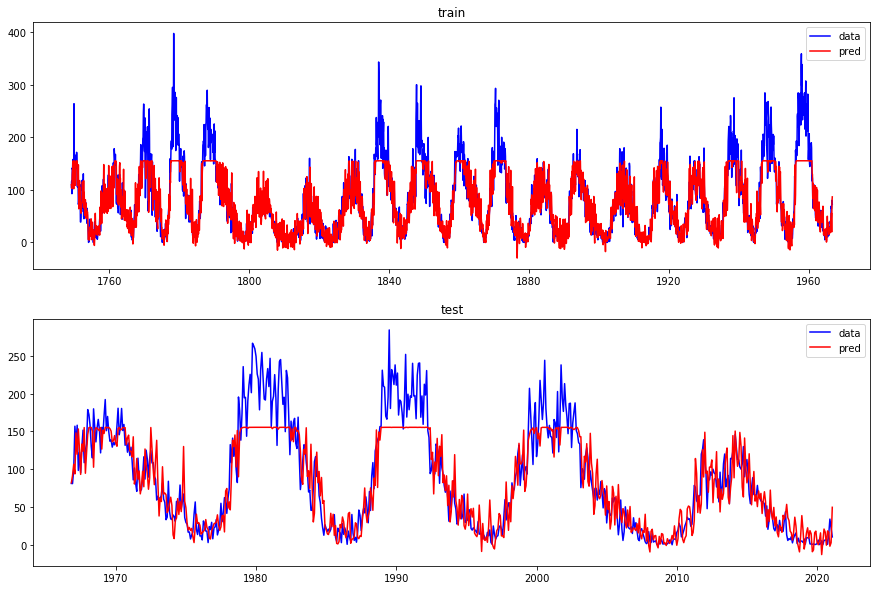

In [21]:
# data4pred
plt.figure(figsize=(15,10))

plt.subplot(211)
data4pred(model,train_forecast_set,trainforcastloader,device)
plt.title("train")


plt.subplot(212)
data4pred(model,test_forecast_set,testforcastloader,device)
plt.title("test")

Text(0.5, 1.0, 'test')

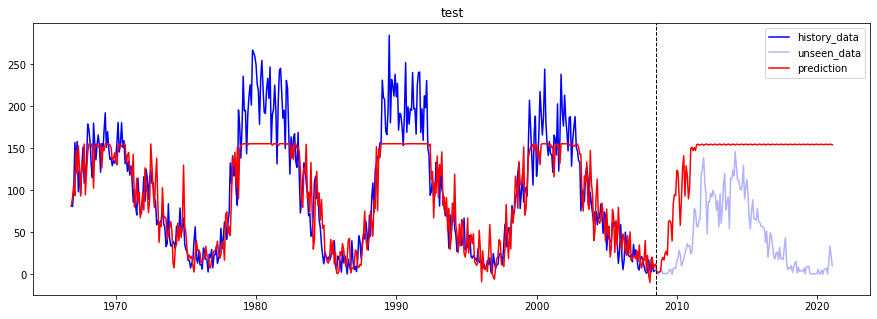

In [22]:
plt.figure(figsize=(15,5))

pred4pred(model,test_forecast_set,testforcastloader,device)
plt.title("test")

---

**menggunakan feature scaling**

In [23]:
df=pd.read_csv("data/Sunspots.csv",index_col="Date",parse_dates=["Date"])
df

,Monthly_Mean_Sunspot
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7
...,...
2020-09-30,0.6
2020-10-31,14.4
2020-11-30,34.0


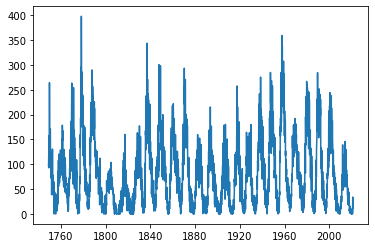

In [24]:
plt.plot(df.Monthly_Mean_Sunspot)

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df[['Monthly_Mean_Sunspot']])

df['Monthly_Mean_Sunspot'] = scaler.transform(df[['Monthly_Mean_Sunspot']])

# Dataset Splitting

In [26]:
from sklearn.model_selection import train_test_split

In [27]:

ts_train, ts_test = train_test_split(df, test_size=0.2,shuffle=False)
ts_train.shape, ts_test.shape

((2612, 1), (653, 1))

# Dataset and Dataloader

In [28]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

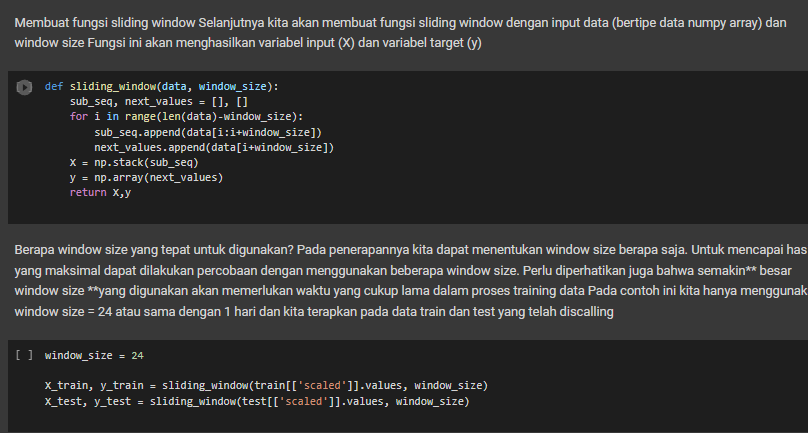

In [29]:
seq_len= 12
bs=64

train_set= TimeSeriesDataset(ts_train,"Monthly_Mean_Sunspot",seq_len)
trainloader=DataLoader(train_set,batch_size=bs)

test_set=TimeSeriesDataset(ts_test,"Monthly_Mean_Sunspot",seq_len)
testloader= DataLoader(test_set,batch_size=bs)

(N, S, F): (217, 12, 1)
Note: last 7 data excluded

(N, S, F): (54, 12, 1)
Note: last 4 data excluded



# Arsitektur and Config

In [30]:
class RNN (nn.Module):
    def __init__(self,input_size,output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.hidden= nn.RNN(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
        
    def forward(self,x,hidden):
        x,hidden= self.hidden(x,hidden)
        x= self.fc(x)
        return x,hidden

In [31]:
config = set_config({
    "batch_size" : bs,
    "seq_len" : train_set.n_seq,
    "input_size" : train_set.n_feature,
    "output_size" : 1,
    "hidden_size" : 128,
    "num_layers" : 2,
    "dropout": 0
})

# Training Preparation ~> MCOC

In [32]:
model = RNN(config.input_size,config.output_size,config.hidden_size,config.num_layers,config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model,config,outdir="model")


# Training Loop

In [33]:
def loop_fn (mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode =="train":
        model.train()
    elif mode == "test":
        model.eval()
        
    cost = 0
    for feature,target in tqdm(dataloader,desc = mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature,None) 
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item()*feature.shape[0]
    cost=cost/len(dataset)
    return cost

In [34]:
from tqdm.auto import tqdm



Epoch     1
Train_cost  = 0.0520 | Test_cost  = 0.0336 | 




Epoch     2
Train_cost  = 0.0288 | Test_cost  = 0.0279 | 




Epoch     3
Train_cost  = 0.0234 | Test_cost  = 0.0192 | 




Epoch     4
Train_cost  = 0.0174 | Test_cost  = 0.0142 | 




Epoch     5
Train_cost  = 0.0116 | Test_cost  = 0.0092 | 




Epoch     6
Train_cost  = 0.0090 | Test_cost  = 0.0082 | 




Epoch     7
Train_cost  = 0.0072 | Test_cost  = 0.0062 | 




Epoch     8
Train_cost  = 0.0064 | Test_cost  = 0.0063 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0062




Epoch     9
Train_cost  = 0.0065 | Test_cost  = 0.0054 | 




Epoch    10
Train_cost  = 0.0056 | Test_cost  = 0.0048 | 




Epoch    11
Train_cost  = 0.0054 | Test_cost  = 0.0049 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0048




Epoch    12
Train_cost  = 0.0054 | Test_cost  = 0.0046 | 




Epoch    13
Train_cost  = 0.0051 | Test_cost  = 0.0045 | 




Epoch    14
Train_cost  = 0.0050 | Test_cost  = 0.0045 | 




Epoch    15
Train_cost  = 0.0049 | Test_cost  = 0.0043 | 




Epoch    16
Train_cost  = 0.0048 | Test_cost  = 0.0043 | 




Epoch    17
Train_cost  = 0.0048 | Test_cost  = 0.0042 | 




Epoch    18
Train_cost  = 0.0047 | Test_cost  = 0.0042 | 




Epoch    19
Train_cost  = 0.0047 | Test_cost  = 0.0041 | 




Epoch    20
Train_cost  = 0.0046 | Test_cost  = 0.0041 | 


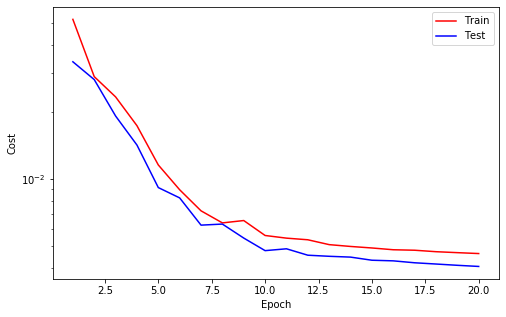



Epoch    21
Train_cost  = 0.0046 | Test_cost  = 0.0040 | 




Epoch    22
Train_cost  = 0.0046 | Test_cost  = 0.0040 | 




Epoch    23
Train_cost  = 0.0045 | Test_cost  = 0.0039 | 




Epoch    24
Train_cost  = 0.0045 | Test_cost  = 0.0039 | 




Epoch    25
Train_cost  = 0.0045 | Test_cost  = 0.0039 | 




Epoch    26
Train_cost  = 0.0045 | Test_cost  = 0.0039 | 




Epoch    27
Train_cost  = 0.0044 | Test_cost  = 0.0038 | 




Epoch    28
Train_cost  = 0.0044 | Test_cost  = 0.0038 | 




Epoch    29
Train_cost  = 0.0044 | Test_cost  = 0.0038 | 




Epoch    30
Train_cost  = 0.0044 | Test_cost  = 0.0038 | 




Epoch    31
Train_cost  = 0.0044 | Test_cost  = 0.0038 | 




Epoch    32
Train_cost  = 0.0044 | Test_cost  = 0.0038 | 




Epoch    33
Train_cost  = 0.0044 | Test_cost  = 0.0038 | 




Epoch    34
Train_cost  = 0.0044 | Test_cost  = 0.0037 | 




Epoch    35
Train_cost  = 0.0044 | Test_cost  = 0.0037 | 




Epoch    36
Train_cost  = 0.0044 | Test_cost  = 0.0037 | 




Epoch    37
Train_cost  = 0.0044 | Test_cost  = 0.0037 | 




Epoch    38
Train_cost  = 0.0044 | Test_cost  = 0.0037 | 




Epoch    39
Train_cost  = 0.0044 | Test_cost  = 0.0037 | 




Epoch    40
Train_cost  = 0.0044 | Test_cost  = 0.0037 | 


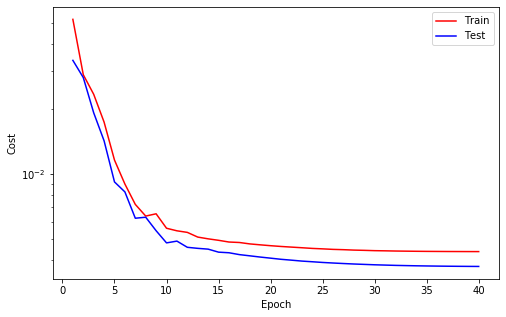



Epoch    41
Train_cost  = 0.0044 | Test_cost  = 0.0037 | 




Epoch    42
Train_cost  = 0.0044 | Test_cost  = 0.0037 | 




Epoch    43
Train_cost  = 0.0044 | Test_cost  = 0.0037 | 




Epoch    44
Train_cost  = 0.0044 | Test_cost  = 0.0037 | 




Epoch    45
Train_cost  = 0.0044 | Test_cost  = 0.0037 | 




Epoch    46
Train_cost  = 0.0044 | Test_cost  = 0.0037 | 




Epoch    47
Train_cost  = 0.0044 | Test_cost  = 0.0037 | 




Epoch    48
Train_cost  = 0.0044 | Test_cost  = 0.0037 | 




Epoch    49
Train_cost  = 0.0044 | Test_cost  = 0.0037 | 




Epoch    50
Train_cost  = 0.0044 | Test_cost  = 0.0037 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0037




Epoch    51
Train_cost  = 0.0044 | Test_cost  = 0.0037 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0037




Epoch    52
Train_cost  = 0.0044 | Test_cost  = 0.0037 | 
==> EarlyStop patience =  3 | Best test_cost: 0.0037




Epoch    53
Train_cost  = 0.0044 | Test_cost  = 0.0037 | 
==> EarlyStop patience =  4 | Best test_cost: 0.0037




Epoch    54
Train_cost  = 0.0044 | Test_cost  = 0.0037 | 
==> EarlyStop patience =  5 | Best test_cost: 0.0037
==> Execute Early Stopping at epoch: 54 | Best test_cost: 0.0037
==> Best model is saved at model


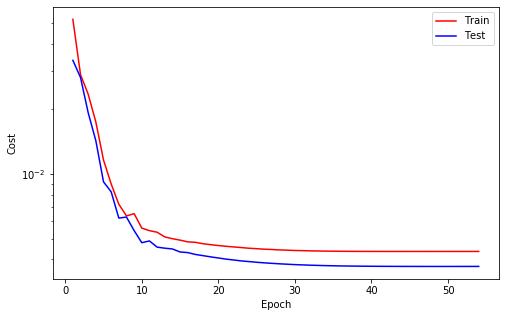

In [35]:
while True :
    train_cost= loop_fn("train",train_set,trainloader,model,criterion,optimizer,device)
    with torch.no_grad():
        test_cost= loop_fn("test",test_set,testloader,model,criterion,optimizer,device)

    callback.log(train_cost, test_cost)


    callback.save_checkpoint()


    callback.cost_runtime_plotting()



    if callback.early_stopping(model, monitor='test_cost'):
        callback.plot_cost()
        break

In [36]:
from luwiji.rnn import illustration

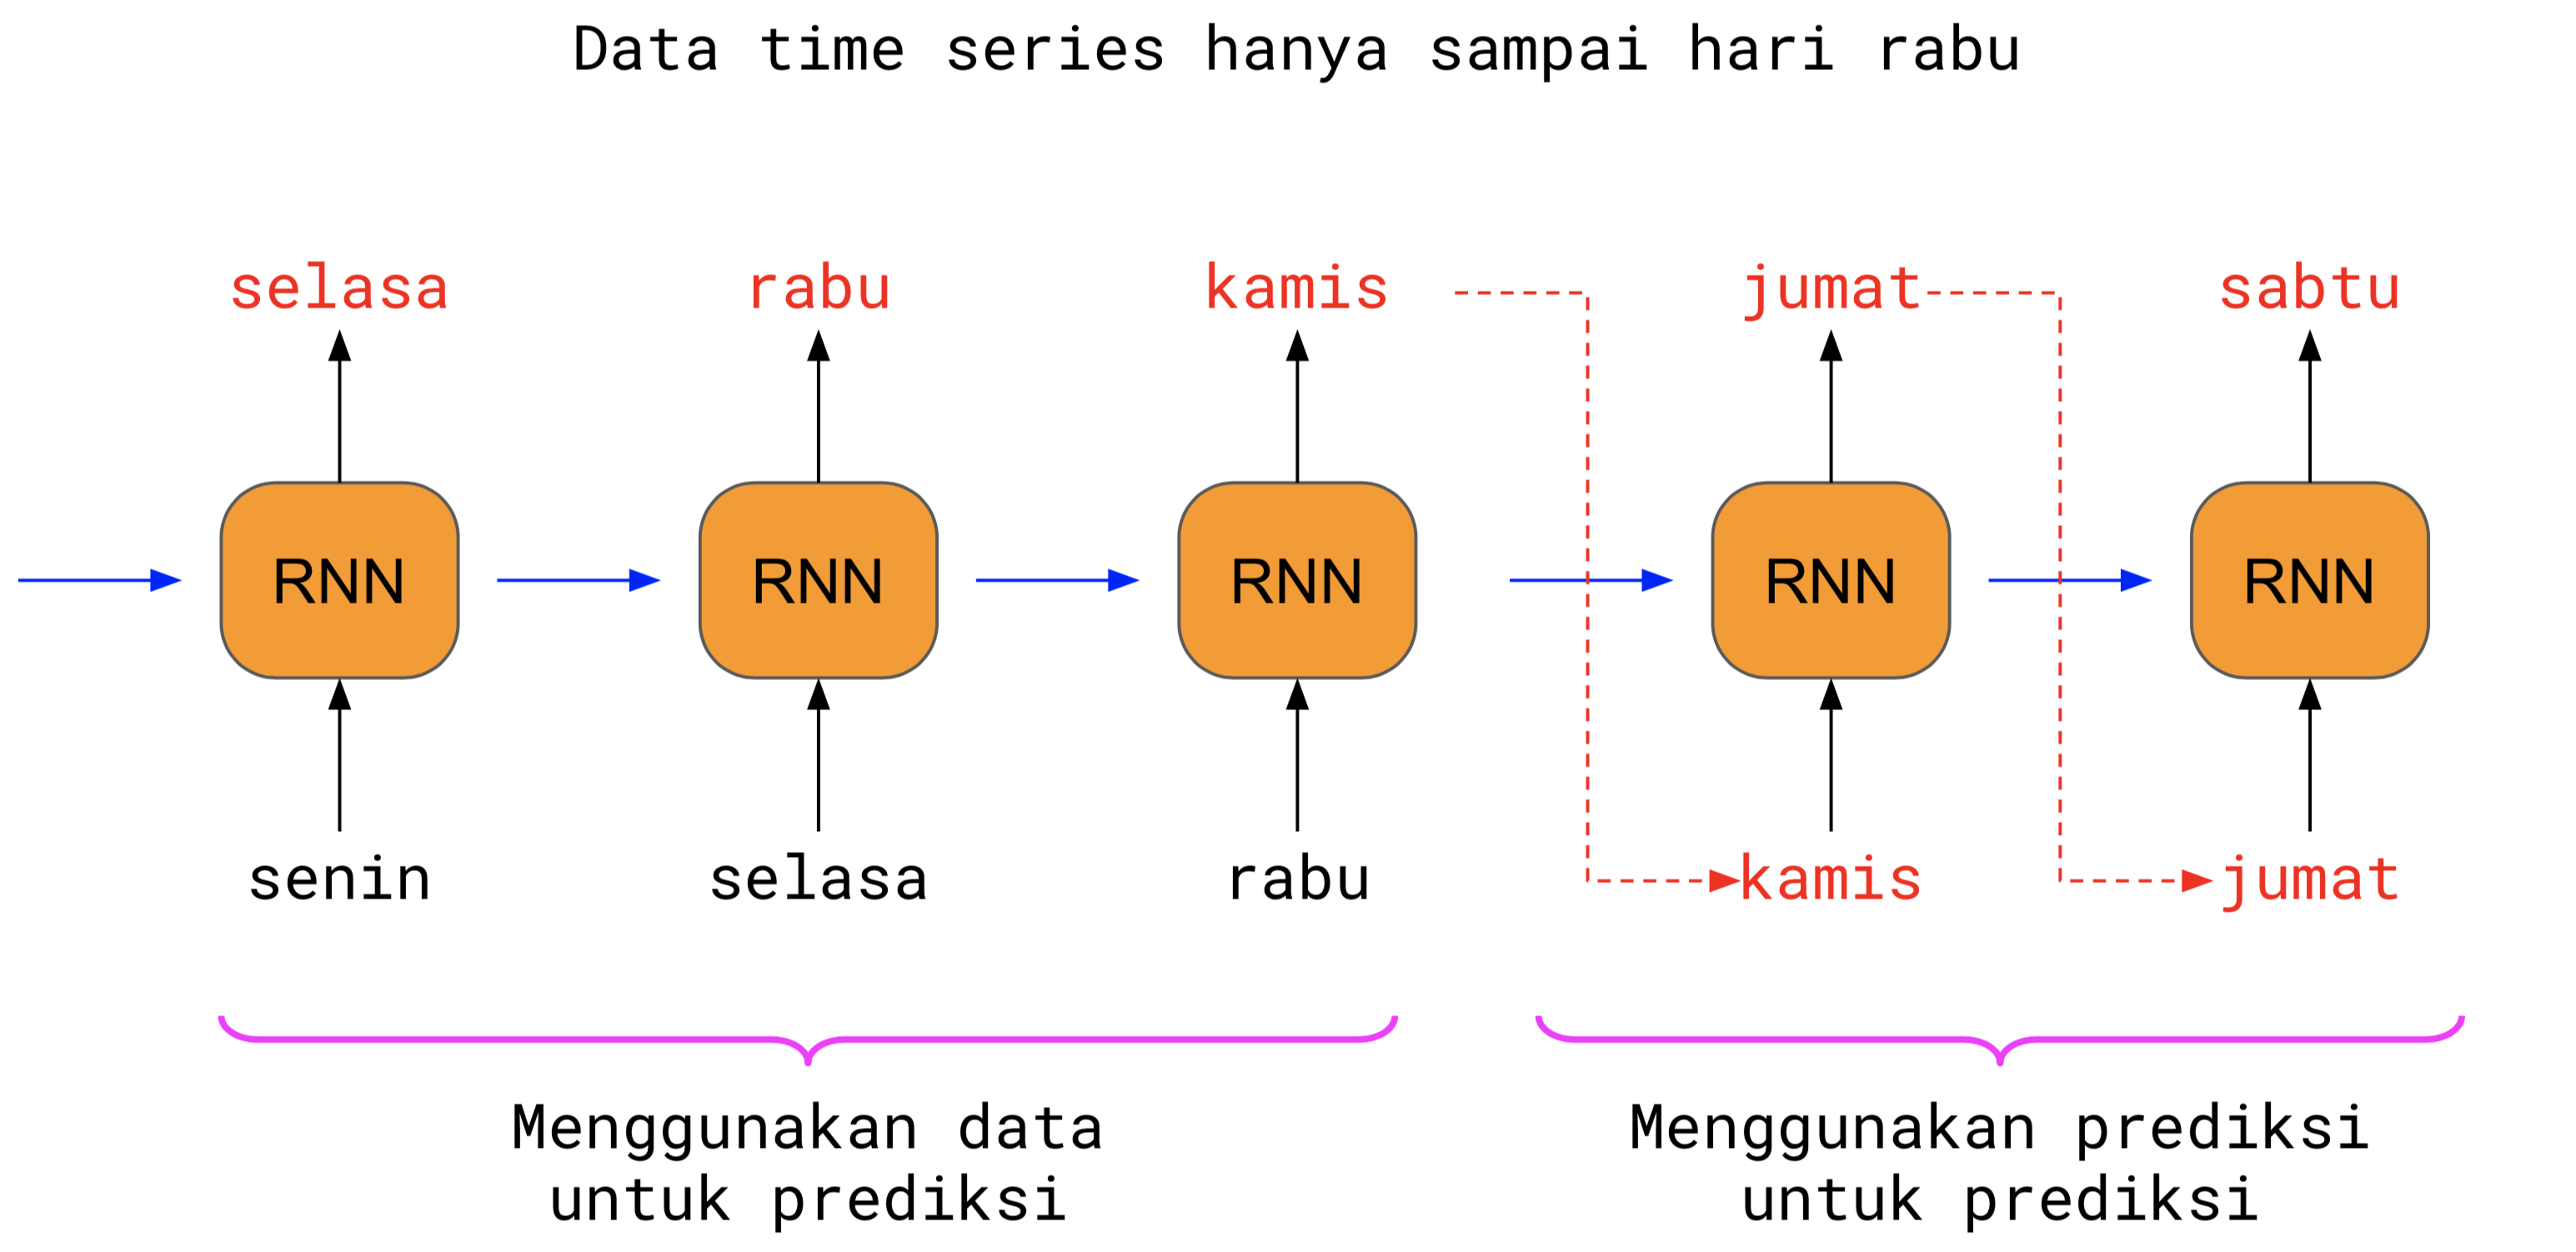

In [37]:
illustration.forecast

forcast untuk data time series itu sangat susah untuk diwujudkan dalam memprediksi dalam jangka panjang, karna apa? karna coba kita pahami illustrasi diatas, dimana pada saat training (menggunakan data untuk prediksi) model kita menggunakan data hari senin untuk memprediksi data hari selasa yang mana data hari selasa kita udah ada dalam dataset training kita, maka nya machine dapat memprediksi data yang ada (ya karna dia update weight, backprop, dll), tapi coba kita telaah lebih lanjut kalau misal nya kita hanya punya data yang dipelajari sampe hari rabu, kita coba untuk menggunakan insight dari data hari seni - rabu itu untuk memprediksi hari kamis dan selanjut nya, maka secara logika model machine kita akan kesusahan atau memiliki error prediksi yang tinggi, karna apa? karna informasi dari data data lalu (senin - rabu) itu gak terlalu bermakna, logika nya gini deh "kalau saya tau suhu di hari rabu, apakah saya bisa tau suhu di hari kamis? kemungkinan besar kita akan salah memprediksi nya" karna apa? karna informasi dari kita hanya mempelajari data data sebelum nya belum menjamin dapat memprediksi data data dikemudian hari selama nya. 
* maka dari itu kita perlu membuat data kita lebih bermakna, seperti kita bagi data misal nya berdasarkan quarter dalam satu tahun, maka itu setidak nya memberikan pola baru kepada machine dalam mempelajari pola.
* menggunakan metode pengembangan dari Recurrent Neural Network juga bisa menjadi solusi nya

In [38]:
from utils import data4pred,pred4pred

In [39]:
train_forecast_set = TimeSeriesDataset(ts_train,"Monthly_Mean_Sunspot",1)
trainforcastloader= DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test,"Monthly_Mean_Sunspot",1)
testforcastloader= DataLoader(test_forecast_set)



(N, S, F): (2611, 1, 1)
Note: last 0 data excluded

(N, S, F): (652, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'test')

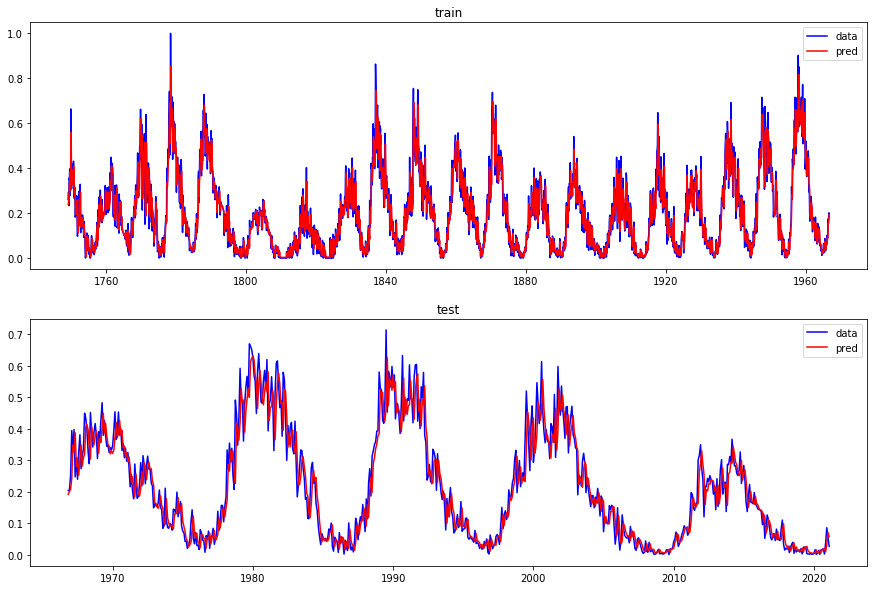

In [40]:
# data4pred
plt.figure(figsize=(15,10))

plt.subplot(211)
data4pred(model,train_forecast_set,trainforcastloader,device)
plt.title("train")


plt.subplot(212)
data4pred(model,test_forecast_set,testforcastloader,device)
plt.title("test")

Text(0.5, 1.0, 'test')

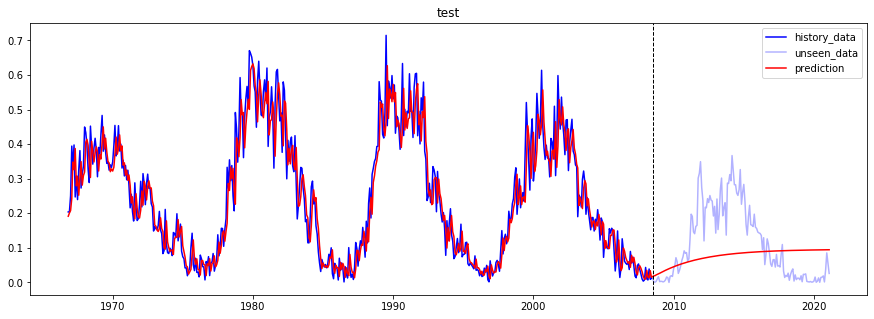

In [41]:
plt.figure(figsize=(15,5))

pred4pred(model,test_forecast_set,testforcastloader,device)
plt.title("test")